In this notebook we explore more about eye tracking data analysis

In [1]:
# Derived from:
#     https://www.axonlab.org/hcph-sops/data-management/eyetrack-qc
# Load the autoreload extension
%load_ext autoreload
# Set autoreload to update the modules every time before executing a new line of code
%autoreload 2

%matplotlib inline
from pathlib import Path
import json
import ppjson
from importlib import reload  # For debugging purposes

import numpy as np
import pandas as pd

import eyetrackingrun as et

from IPython.display import HTML
from matplotlib import animation
from matplotlib.animation import FuncAnimation, PillowWriter
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import copy
from write_bids_yiwei import EyeTrackingRun, write_bids, write_bids_from_df

In [2]:
subject_idx = 1
T_idx = 1

if T_idx == 1:
    mode = 'T1'
else:
    mode = 'T2'

if subject_idx == 1:
    BIDS_PATH = Path("C:\\yiwei\\1_Pilot_MREye_Data\\Sub001\\230928_anatomical_MREYE_study\\ET_EDF")
    FILE_NAME = f"JB{T_idx}"    
elif subject_idx == 2:
    BIDS_PATH = Path("C:\\yiwei\\1_Pilot_MREye_Data\\Sub002\\230926_anatomical_MREYE_study\\ET_EDF")
    FILE_NAME = f"BF_T{T_idx}" 
elif subject_idx == 3:
    BIDS_PATH = Path("C:\\yiwei\\1_Pilot_MREye_Data\\Sub003\\230928_anatomical_MREYE_study\\ET_EDF")
    FILE_NAME = f"OT{2*T_idx}"
    # "OT4.EDF"
else:
    BIDS_PATH = Path("C:\\yiwei\\1_Pilot_MREye_Data\\Sub004\\230923_anatomical_MREYE_study\\ET_EDF")
    FILE_NAME = f"HV{T_idx}"
    
# D:\Eye_Dataset\Sub001\230928_anatomical_MREYE_study\ET_EDF
session = "001" #can be a string to be defined when required
tsv_name = f"{FILE_NAME}.tsv.gz"
gif_name = f'{FILE_NAME}.gif'


In [3]:
# Read in tsv.gz file
# Naming convension can be modified later
# recording_file = BIDS_PATH / "sub-001" / f"ses-{session}" / "dwi" / f"sub-001_ses-{session}_acq-highres_dir-RL_recording-eyetrack_physio.tsv.gz"
recording_file = BIDS_PATH / tsv_name
print(f'recording_file: {recording_file}')
recording = pd.read_csv(
    recording_file,
#     sep=r"\s+",
    sep="\t",
    na_values="n/a",
)
recording.head()
print(f'recording len: {len(recording)}')
metadata = json.loads((
    recording_file.parent
    / recording_file.name.replace(".tsv.gz", ".json")
).read_text())
print(f'meta_data: {metadata}')

print('The duration of sub001 t1: 374557.5 ms -> 374558 ms')
print('The duration of sub002 t1: 374380 ms')

recording_file: C:\yiwei\1_Pilot_MREye_Data\Sub001\230928_anatomical_MREYE_study\ET_EDF\JB1.tsv.gz
recording len: 754932
meta_data: {'AverageCalibrationError': [0.5], 'CalibrationCount': 1, 'CalibrationLog': [[1047679, '>>>>>>> CALIBRATION (HV5,P-CR) FOR RIGHT: <<<<<<<<<'], [1047679, 'Calibration points:'], [1047680, '-10.3, -50.9         0,      0'], [1047680, '-8.9, -71.9         0,  -2457'], [1047680, '-9.3, -29.2         0,   2457'], [1047680, '-41.2, -50.5     -3474,      0'], [1047680, '24.2, -49.8      3474,      0'], [1047680, 'eye check box: (L,R,T,B)\n\t  -48    31   -76   -25'], [1047680, 'href cal range: (L,R,T,B)\n\t-5211  5211 -3686  3686'], [1047680, 'Cal coeff:(X=a+bx+cy+dxx+eyy,Y=f+gx+goaly+ixx+jyy)\n   5.882e-05  107.02  1.2434 -0.18295 -0.27969 \n   4.4115e-05 -0.84952  115.02 -0.085003 -0.090966'], [1047680, 'Prenormalize: offx, offy = -10.326 -50.929'], [1047680, 'Gains: cx:102.441 lx:116.794 rx:88.586'], [1047680, 'Gains: cy:109.181 ty:118.022 by:110.039'], [10476

# Metadata and calibration

We always run a calibration before it is started. As a result, we will typically see the metadata corresponding to calibration on this particular run.

Now, let's print out the contents of the BIDS' sidecar JSON corresponding to the DWI in this session.

In [4]:
recording

,Unnamed: 0,eye1_x_coordinate,eye1_y_coordinate,eye1_pupil_size,eye1_pupil_x_coordinate,eye1_pupil_y_coordinate,eye1_href_x_coordinate,eye1_href_y_coordinate,fast_raw_x_velocity,screen_ppdeg_x_coordinate,screen_ppdeg_y_coordinate,timestamp,eye1_fixation,eye1_saccade,eye1_blink
0,0,599.799988,440.299988,2721.0,1126.0,-4793.0,1972.0,1384.0,4.591214e-41,27.1,26.9,1084634,0,0,0
1,1,600.000000,441.299988,2718.0,1129.0,-4782.0,1974.0,1394.0,4.591214e-41,27.1,26.9,1084635,0,0,0
2,2,600.700012,442.399994,2716.0,1138.0,-4769.0,1981.0,1405.0,4.591214e-41,27.1,26.9,1084636,0,0,0
3,3,601.400024,442.700012,2709.0,1147.0,-4766.0,1988.0,1408.0,4.591214e-41,27.1,26.9,1084637,0,0,0
4,4,601.799988,443.000000,2704.0,1152.0,-4762.0,1991.0,1411.0,4.591214e-41,27.1,26.9,1084638,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754927,754927,458.500000,335.299988,5546.0,-610.0,-5978.0,577.0,348.0,-6.010000e+03,26.5,26.5,1839561,1,0,0
754928,754928,458.500000,335.899994,5540.0,-610.0,-5971.0,578.0,354.0,-6.010000e+03,26.5,26.5,1839562,1,0,0
754929,754929,458.500000,336.399994,5530.0,-610.0,-5966.0,578.0,359.0,-6.010000e+03,26.5,26.5,1839563,1,0,0
754930,754930,458.500000,335.899994,5520.0,-610.0,-5971.0,577.0,355.0,-6.010000e+03,26.5,26.5,1839564,1,0,0


In [5]:
t_axis = (
    recording.timestamp.values - recording.timestamp[0]
) / metadata["SamplingFrequency"]
print(f"The end of the timestamp: {t_axis[-1]}")

The end of the timestamp: 754.931


In [6]:
print(metadata["Columns"])
recording = recording.rename(
        columns={
            f"eye1_pupil_size": f"pupil_size",
            f"eye1_fixation": f"fixation",
            f"eye1_saccade": f"saccade",
            f"eye1_blink": f"blink",
            f"eye1_x_coordinate": f"x_coordinate", 
            f"eye1_y_coordinate": f"y_coordinate"         
        }
    )

metadata["Columns"] = recording.columns.tolist()
print(metadata["Columns"])

['eye1_x_coordinate', 'eye1_y_coordinate', 'eye1_pupil_size', 'eye1_pupil_x_coordinate', 'eye1_pupil_y_coordinate', 'eye1_href_x_coordinate', 'eye1_href_y_coordinate', 'fast_raw_x_velocity', 'screen_ppdeg_x_coordinate', 'screen_ppdeg_y_coordinate', 'timestamp', 'eye1_fixation', 'eye1_saccade', 'eye1_blink']
['Unnamed: 0', 'x_coordinate', 'y_coordinate', 'pupil_size', 'eye1_pupil_x_coordinate', 'eye1_pupil_y_coordinate', 'eye1_href_x_coordinate', 'eye1_href_y_coordinate', 'fast_raw_x_velocity', 'screen_ppdeg_x_coordinate', 'screen_ppdeg_y_coordinate', 'timestamp', 'fixation', 'saccade', 'blink']


In [7]:
recording.columns

Index(['Unnamed: 0', 'x_coordinate', 'y_coordinate', 'pupil_size',
       'eye1_pupil_x_coordinate', 'eye1_pupil_y_coordinate',
       'eye1_href_x_coordinate', 'eye1_href_y_coordinate',
       'fast_raw_x_velocity', 'screen_ppdeg_x_coordinate',
       'screen_ppdeg_y_coordinate', 'timestamp', 'fixation', 'saccade',
       'blink'],
      dtype='object')

Check the pupil area

In [8]:
check_pupil = False
if check_pupil:
    fig = plt.figure(figsize=(16, 2))
    plt.plot(
        t_axis,
        recording["pupil_size"].values,
    )

    plt.xlabel("time [s]")
    plt.ylabel("pupil area [a.u.]");

    fig = plt.figure(figsize=(16, 2))
    plt.plot(
        t_axis,
        recording["pupil_size"].values,
    )
    plt.title("Zoom In - Pupil Area")
    plt.xlabel("time [s]")
    plt.ylabel("pupil area [a.u.]")
    # JB1 (100, 150)
    plt.xlim((100, 150))

Check the eye events:

 - Blink
    
- Saccade
    
- Fixation

Check blinking

In [9]:
check_blink = False
if check_blink:
    fig = plt.figure(figsize=(16, 2))
    plt.plot(
        t_axis,
        recording["blink"].values,
    )
    plt.title("Blink Event")
    plt.xlabel("time [s]")
    plt.ylabel("eyes closed");

    fig = plt.figure(figsize=(16, 2))
    plt.plot(
        t_axis,
        recording["blink"].values * 10000,
    )
    plt.xlabel("time [s]")
    plt.ylabel("eyes closed")
    plt.title("Zoom in - Blink Event")
    plt.xlim((100, 150))

In [10]:
plot_pupil_blink = False
if plot_pupil_blink:
    fig = plt.figure(figsize=(16, 2))

    plt.plot(
        t_axis,
        recording["pupil_size"].values,
    )

    plt.plot(
        t_axis,
        recording["blink"].values * 5000,
    )

    plt.xlabel("time [s]")
    plt.ylabel("pupil area [a.u.]")
    plt.xlim((100, 140))
    plt.title('Pupil area and blinking')

    print(f'At this time, since blinking is detected, we cannot get clear pupil area ?')

Check saccading

In [11]:
Check_saccading=False
if Check_saccading:
    fig = plt.figure(figsize=(16, 2))
    plt.plot(
        t_axis,
        recording["saccade"].values,
    )
    plt.title("Saccade Event")
    plt.xlabel("time [s]")
    plt.ylabel("eyes closed");

    fig = plt.figure(figsize=(16, 2))
    plt.plot(
        t_axis,
        recording["saccade"].values * 10000,
    )
    plt.xlabel("time [s]")
    plt.ylabel("eyes closed")
    plt.title("Zoom in - Saccade Event")
    plt.xlim((100, 150))

In [12]:
plot_pupil_saccade = False

if plot_pupil_saccade:
    fig = plt.figure(figsize=(16, 2))

    plt.plot(
        t_axis,
        recording["pupil_size"].values,
    )

    plt.plot(
        t_axis,
        recording["saccade"].values * 5000,
    )

    plt.xlabel("time [s]")
    plt.ylabel("pupil area [a.u.]")
    plt.xlim((200, 220))
    plt.title('Pupil area and saccading')
    print(f'At this time, since blinking is detected, we cannot get clear pupil area ?')

In [13]:
plot_x_saccade = False
if plot_x_saccade:
    fig = plt.figure(figsize=(16, 2))
    plt.plot(
        t_axis,
        recording["x_coordinate"].values,
    )

    plt.plot(
        t_axis,
        recording["saccade"].values * 1000,
    )
    plt.xlim((200, 220))

Check fixation

In [14]:
plot_fixation = False
if plot_fixation:
    # Fixation
    fig = plt.figure(figsize=(16, 2))
    plt.plot(
        t_axis,
        recording["x_coordinate"].values,
    )

    plt.plot(
        t_axis,
        recording["fixation"].values * 500,
    )
    plt.xlim((340, 350))
    plt.title('X coordinate of gazing with fixation')

    fig = plt.figure(figsize=(16, 2))
    plt.plot(
        t_axis,
        recording["y_coordinate"].values,
    )

    plt.plot(
        t_axis,
        recording["fixation"].values * 500,
    )
    plt.xlim((340, 350))
    plt.title('Y coordinate of gazing with fixation')

The analysis did not reveal a strong correlation between pupil size and saccade or fixation events.

The coordinate sequence is stable during fixation, we should extract the data in the event.

## T1-weighted 

- name psychopy and ET data: JB1

- duration of the protocol: 720sec (12 min)

- Our protocol (p178 6:02 min + 15.03s + 05:57 min)

- differences between the two sequence: 15.03 sec

- ET calibration: 5 points

- LIBRE Voxel size: 0.5mm * 0.5mm * 0.5mm

- VIBE Voxel size: 0.4mm * 0.4mm * 0.4mm

## T2-weighted 

- name psychopy and ET data: JB2

- duration of the protocol: 1105sec (ca. 18 min)

- Our protocol (p178 10:42 min + 7.15s + 07:32 min)

- differences between the two sequence: 

- ET calibration: 5 points

- LIBRE Voxel size: 0.5mm * 0.5mm * 0.5mm

- TSE Voxel size: 0.3mm * 0.3mm * 1.5mm


# Data Cleaning

- Seperate the two phases of sequences
- Extract the X Y coordinates
- Eliminate the blinking and non-fixation area of LIBRE data, and keep the raw data of STANDARD.Because there is no mechanism for the second STANDARD one to correct the eye fixation.
- Design some criteria for cleaning the noise data
    - Visual angle
    - Heat maps
    - Fixation algorithm (literature review)

### Seperate the two phases of sequences

In [15]:
# Duration setting according to the protocol (in sec) not any more
# Duration setting according to the raw data info

if  subject_idx == 1:
    T1_LIBRE = 374.558
elif subject_idx == 2:
    T1_LIBRE = 374.380
else:
    T1_LIBRE = 6*60+2
    
T1_GAP = 15.03
T1_VIBE = 5*60+57

T2_LIBRE = 10*60+42
T2_GAP = 7.15
T2_TSE = 7*60+32

length_T1 = metadata['SamplingFrequency']*(T1_LIBRE+T1_GAP+T1_VIBE)
print(f"The length of T1 should be: {length_T1}")
length_T2 = metadata['SamplingFrequency']*(T2_LIBRE+T2_GAP+T2_TSE)
print(f"The length of T2 should be: {length_T2}")

The length of T1 should be: 746588.0
The length of T2 should be: 1101150.0


In [16]:
# -----------------------------
reset_index_bool = False
eliminate_all_nan = False
eliminate_first_nan = False
# -----------------------------

size = (
    metadata["ScreenAOIDefinition"][1][1],
    metadata["ScreenAOIDefinition"][1][3],
)

coor_data = recording[["x_coordinate", "y_coordinate"]]
print(f"Extract X Y coordinates from recording: {len(coor_data)}")

if eliminate_all_nan:
    coor_data = coor_data[coor_data.x_coordinate.notna() & coor_data.y_coordinate.notna()]
    coor_recording = recording[recording.x_coordinate.notna() & recording.y_coordinate.notna()]
elif eliminate_first_nan:
    # Find the first non-NaN row
    first_valid_index = coor_data[['x_coordinate', 'y_coordinate']].dropna(how='all').index[0]

    # Slice the DataFrame from the first non-NaN row onward
    coor_data = coor_data.iloc[first_valid_index:]
    
    coor_recording = recording.iloc[first_valid_index:]
    
else:
    coor_recording = recording

if reset_index_bool:
    coor_data.reset_index(drop=True, inplace=True)
    coor_recording.reset_index(drop=True, inplace=True)
    
print(coor_data)
print(f"Eliminating nan values? {eliminate_first_nan}: {len(coor_data)}")
print(f'len of coor_data {len(coor_data)} should be equal to len of coor_recording {len(coor_recording)}')

Extract X Y coordinates from recording: 754932
        x_coordinate  y_coordinate
0         599.799988    440.299988
1         600.000000    441.299988
2         600.700012    442.399994
3         601.400024    442.700012
4         601.799988    443.000000
...              ...           ...
754927    458.500000    335.299988
754928    458.500000    335.899994
754929    458.500000    336.399994
754930    458.500000    335.899994
754931    458.500000    335.200012

[754932 rows x 2 columns]
Eliminating nan values? False: 754932
len of coor_data 754932 should be equal to len of coor_recording 754932


mode: T1
set start margin as 0
374558
365344


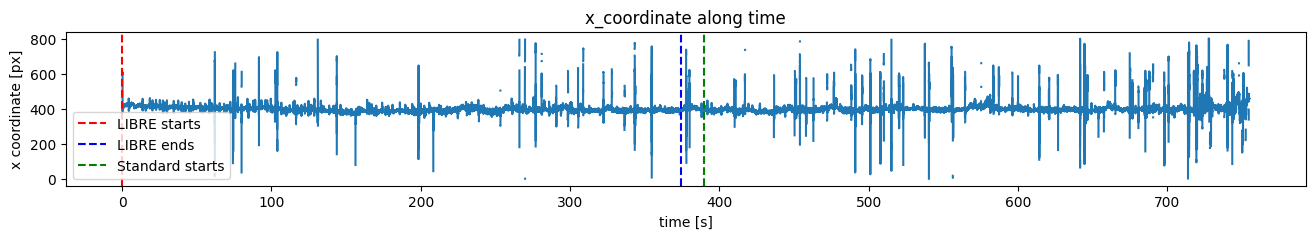

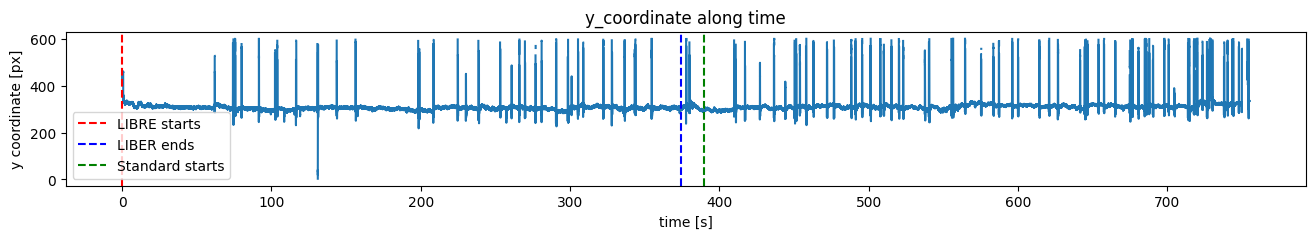

In [17]:
start_margin = int(0.0*metadata['SamplingFrequency'])
if mode == 'T1':
    print(f'mode: {mode}')
    print(f"set start margin as {start_margin}")
    T1_LIBRE_sample = T1_LIBRE*metadata['SamplingFrequency']
    T1_GAP_sample = T1_GAP*metadata['SamplingFrequency']
    T1_VIBE = len(coor_data) - T1_LIBRE_sample - T1_GAP_sample
else:
    print(f'mode: {mode}')
    print(f"set start margin as {start_margin}")
    T2_LIBRE_sample = T2_LIBRE*metadata['SamplingFrequency']
    T2_GAP_sample = T2_GAP*metadata['SamplingFrequency']
    T2_TSE = len(coor_data) - T2_LIBRE_sample - T2_GAP_sample
    


t_axis_xy = (
    coor_data.index 
) / metadata["SamplingFrequency"]

# x coordinate
fig = plt.figure(figsize=(16, 2))

plt.plot(
    t_axis_xy,
    coor_data["x_coordinate"].values,
)

if mode == 'T1':
    plt.axvline(x=start_margin/metadata["SamplingFrequency"], color='r', linestyle='--', label='LIBRE starts')
    plt.axvline(x=(T1_LIBRE_sample+start_margin)/metadata["SamplingFrequency"], color='b', linestyle='--', label='LIBRE ends')
    plt.axvline(x=(T1_LIBRE_sample+start_margin+T1_GAP_sample)/metadata["SamplingFrequency"], color='g', 
                linestyle='--', label='Standard starts')
else:
    plt.axvline(x=start_margin/metadata["SamplingFrequency"], color='r', linestyle='--', label='LIBRE starts')
    plt.axvline(x=(T2_LIBRE_sample+start_margin)/metadata["SamplingFrequency"], color='b', linestyle='--', label='LIBRE ends')
    plt.axvline(x=(T2_LIBRE_sample+start_margin+T2_GAP_sample)/metadata["SamplingFrequency"], color='g', 
                linestyle='--', label='Standard starts')
    
plt.title("x_coordinate along time")
plt.xlabel("time [s]")
plt.ylabel("x coordinate [px]")
plt.legend()

# y coordinate
fig = plt.figure(figsize=(16, 2))

plt.plot(
    t_axis_xy,
    coor_data["y_coordinate"].values,
)
if mode == "T1":
    plt.axvline(x=start_margin/metadata["SamplingFrequency"], color='r', linestyle='--', label='LIBRE starts')
    plt.axvline(x=(T1_LIBRE_sample+start_margin)/ metadata["SamplingFrequency"], color='b', linestyle='--', label='LIBER ends')
    plt.axvline(x=(T1_LIBRE_sample+start_margin+T1_GAP_sample)/metadata["SamplingFrequency"], color='g', 
                linestyle='--', label='Standard starts')
else:
    plt.axvline(x=start_margin/metadata["SamplingFrequency"], color='r', linestyle='--', label='LIBRE starts')
    plt.axvline(x=(T2_LIBRE_sample+start_margin)/ metadata["SamplingFrequency"], color='b', linestyle='--', label='LIBER ends')
    plt.axvline(x=(T2_LIBRE_sample+start_margin+T2_GAP_sample)/metadata["SamplingFrequency"], color='g', 
                linestyle='--', label='Standard starts')
    
plt.title("y_coordinate along time")
plt.xlabel("time [s]")
plt.ylabel("y coordinate [px]")
plt.legend()

if mode == 'T1':
    coor_data_LIBRE = coor_data[start_margin:int(T1_LIBRE_sample)] 
    coor_recording_LIBRE = coor_recording[start_margin:int(T1_LIBRE_sample)] 
    coor_data_STANDARD = coor_data[int(T1_LIBRE_sample+start_margin+T1_GAP_sample):] 
    coor_recording_STANDARD = coor_recording[int(T1_LIBRE_sample+start_margin+T1_GAP_sample):] 
else:
    coor_data_LIBRE = coor_data[start_margin:int(T2_LIBRE_sample)] 
    coor_recording_LIBRE = coor_recording[start_margin:int(T2_LIBRE_sample)] 
    coor_data_STANDARD = coor_data[int(T2_LIBRE_sample+start_margin+T2_GAP_sample):] 
    coor_recording_STANDARD = coor_recording[int(T2_LIBRE_sample+start_margin+T2_GAP_sample):] 
coor_data_LIBRE_raw = copy.deepcopy(coor_data_LIBRE)
print(len(coor_data_LIBRE))
print(len(coor_data_STANDARD))

### Eliminating blinking

In [18]:
def eliminate_blink(coor_data, coor_recording, seq_name):
#     coor_data = coor_data[coor_recording.blink < 1]
#     coor_recording = coor_recording[coor_recording.blink < 1]
# Note: instead of filtering them out, I assign nan to the invalid elements
    print(f'The data will be eliminated: {len(coor_data[coor_recording.blink > 0])}')
    coor_data.loc[coor_recording.blink > 0,  ['x_coordinate', 'y_coordinate']] = np.nan
    coor_recording.loc[coor_recording.blink > 0,  ['x_coordinate', 'y_coordinate']] = np.nan
    print(f'After eliminating blinking: \nlen of coor_data_{seq_name} {len(coor_data)} \
      should be equal to len of coor_recording {len(coor_recording)}')
    return coor_data, coor_recording

coor_data_LIBRE,  coor_recording_LIBRE = eliminate_blink(coor_data_LIBRE, coor_recording_LIBRE, 'LIBRE')
# coor_data_STANDARD,  coor_recording_STANDARD = eliminate_blink(coor_data_STANDARD, 
#                                                                coor_recording_STANDARD, 'STANDARD')
plot_heatmap = False
if plot_heatmap:
    import plot
    plot.plot_heatmap_coordinate(coor_data_LIBRE, density=False, screen_size=size, 
                                 title='LIBRE: The gaze from the beginning to the end')
    plot.plot_heatmap_coordinate(coor_data_STANDARD, density=False, screen_size=size, 
                                 title='STANDARD: The gaze from the beginning to the end')

The data will be eliminated: 9513
After eliminating blinking: 
len of coor_data_LIBRE 374558       should be equal to len of coor_recording 374558


C:\Users\jaime.barranco\.conda\envs\edfenv\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\jaime.barranco\.conda\envs\edfenv\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
C:\Users\jaime.barranco\.conda\envs\edfenv\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [21]:
# # inspect the blinking
# coor_data_LIBRE[coor_recording_LIBRE.blink > 0]

### Preserving fixation

In [22]:
def preserve_fixation(coor_data, coor_recording, seq_name):
#     coor_data = coor_data[coor_recording.fixation > 0]
#     coor_recording = coor_recording[coor_recording.fixation > 0]
    print(f'The data will be eliminated: {len(coor_data[coor_recording.fixation < 1])}')
    coor_data.loc[coor_recording.fixation < 1, ['x_coordinate', 'y_coordinate']] = np.nan
    coor_recording.loc[coor_recording.fixation < 1, ['x_coordinate', 'y_coordinate']] = np.nan

    print(f'After preserving fixation: \nlen of coor_data_{seq_name} {len(coor_data)} \
      should be equal to len of coor_recording {len(coor_recording)}')
    return coor_data, coor_recording

coor_data_LIBRE,  coor_recording_LIBRE = preserve_fixation(coor_data_LIBRE, coor_recording_LIBRE, 'LIBRE')
# coor_data_STANDARD,  coor_recording_STANDARD = preserve_fixation(coor_data_STANDARD, 
#                                                                coor_recording_STANDARD, 'STANDARD')
plot_heatmap = False
if plot_heatmap:
    import plot
    plot.plot_heatmap_coordinate(coor_data_LIBRE, density=False, screen_size=size, 
                                 title='LIBRE: The gaze from the beginning to the end')
    plot.plot_heatmap_coordinate(coor_data_STANDARD, density=False, screen_size=size, 
                                 title='STANDARD: The gaze from the beginning to the end')

The data will be eliminated: 21482
After preserving fixation: 
len of coor_data_LIBRE 374558       should be equal to len of coor_recording 374558


C:\Users\jaime.barranco\.conda\envs\edfenv\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\jaime.barranco\.conda\envs\edfenv\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
C:\Users\jaime.barranco\.conda\envs\edfenv\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

### Plot the gazing dots

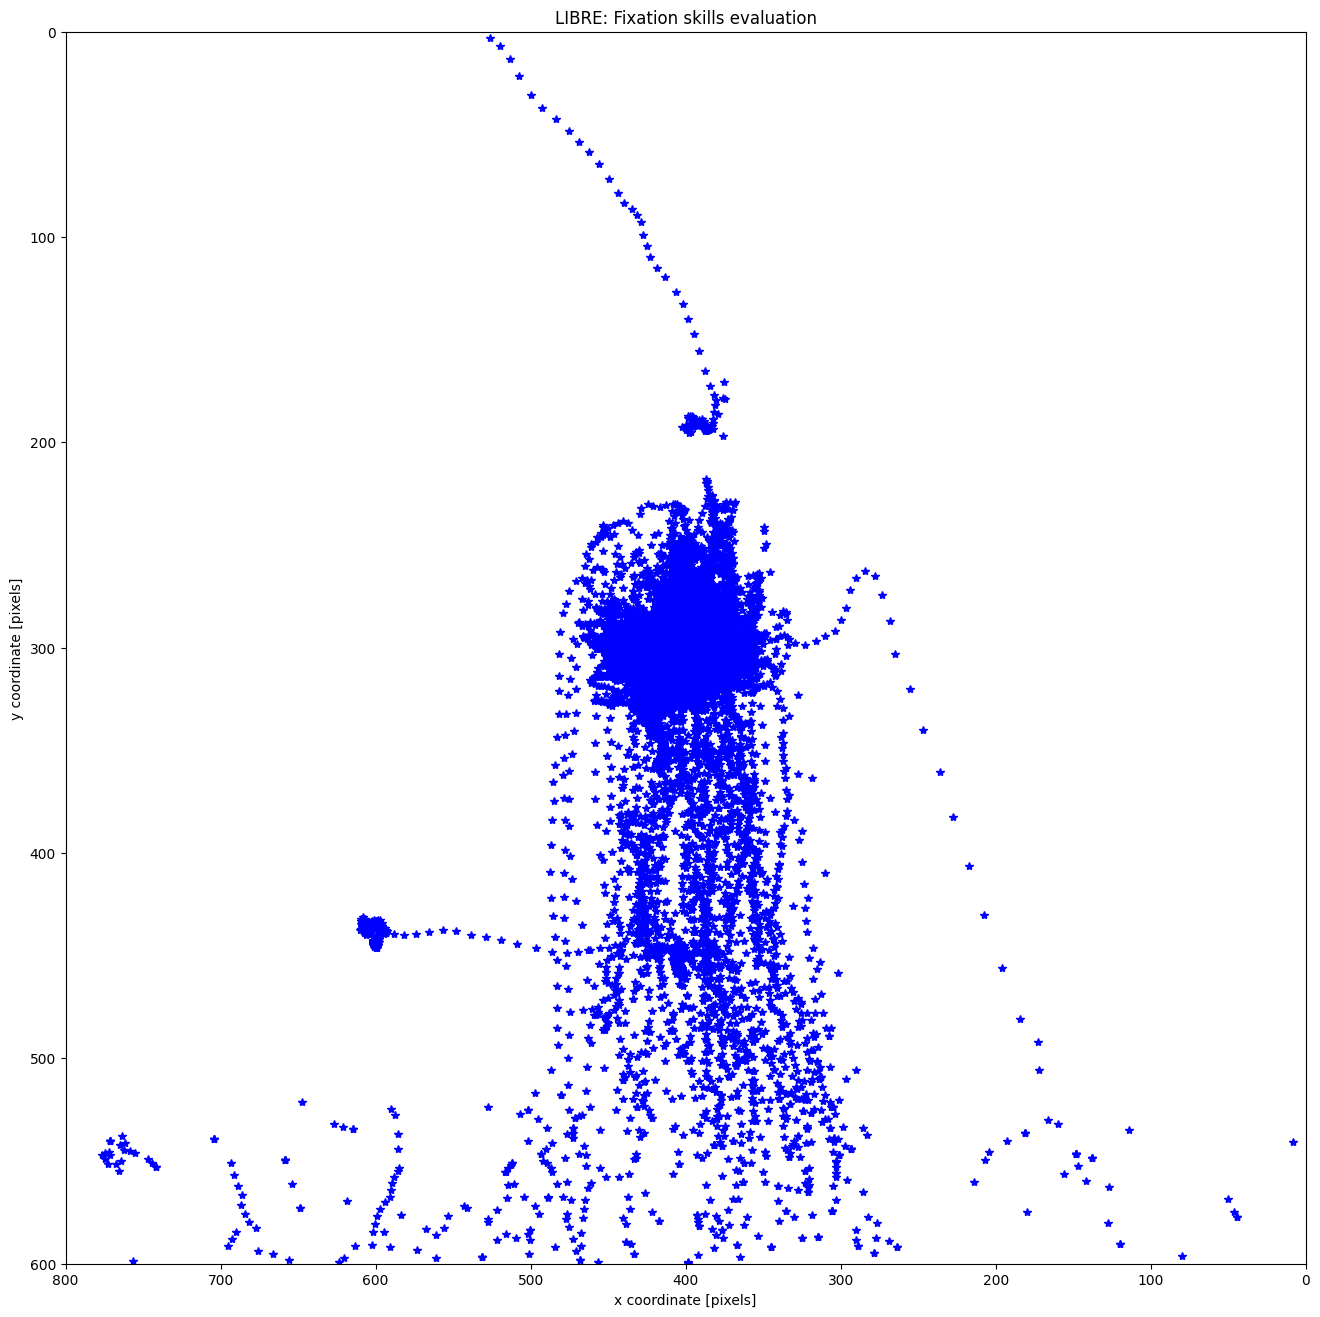

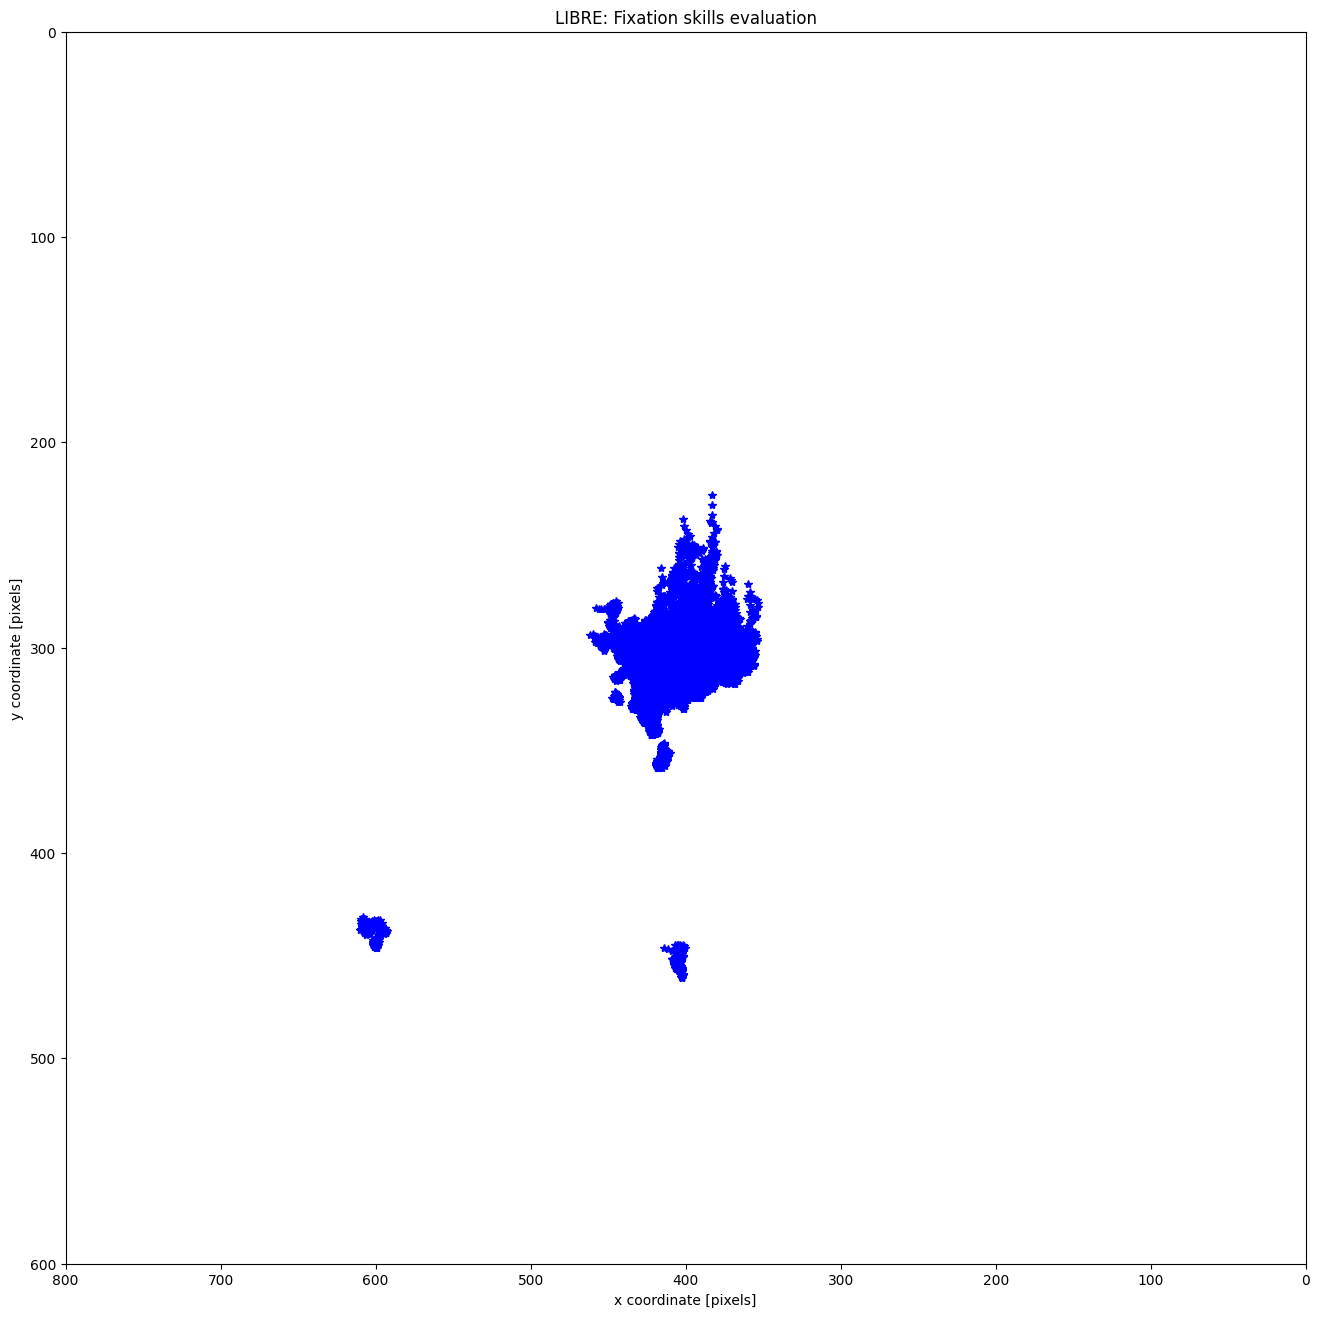

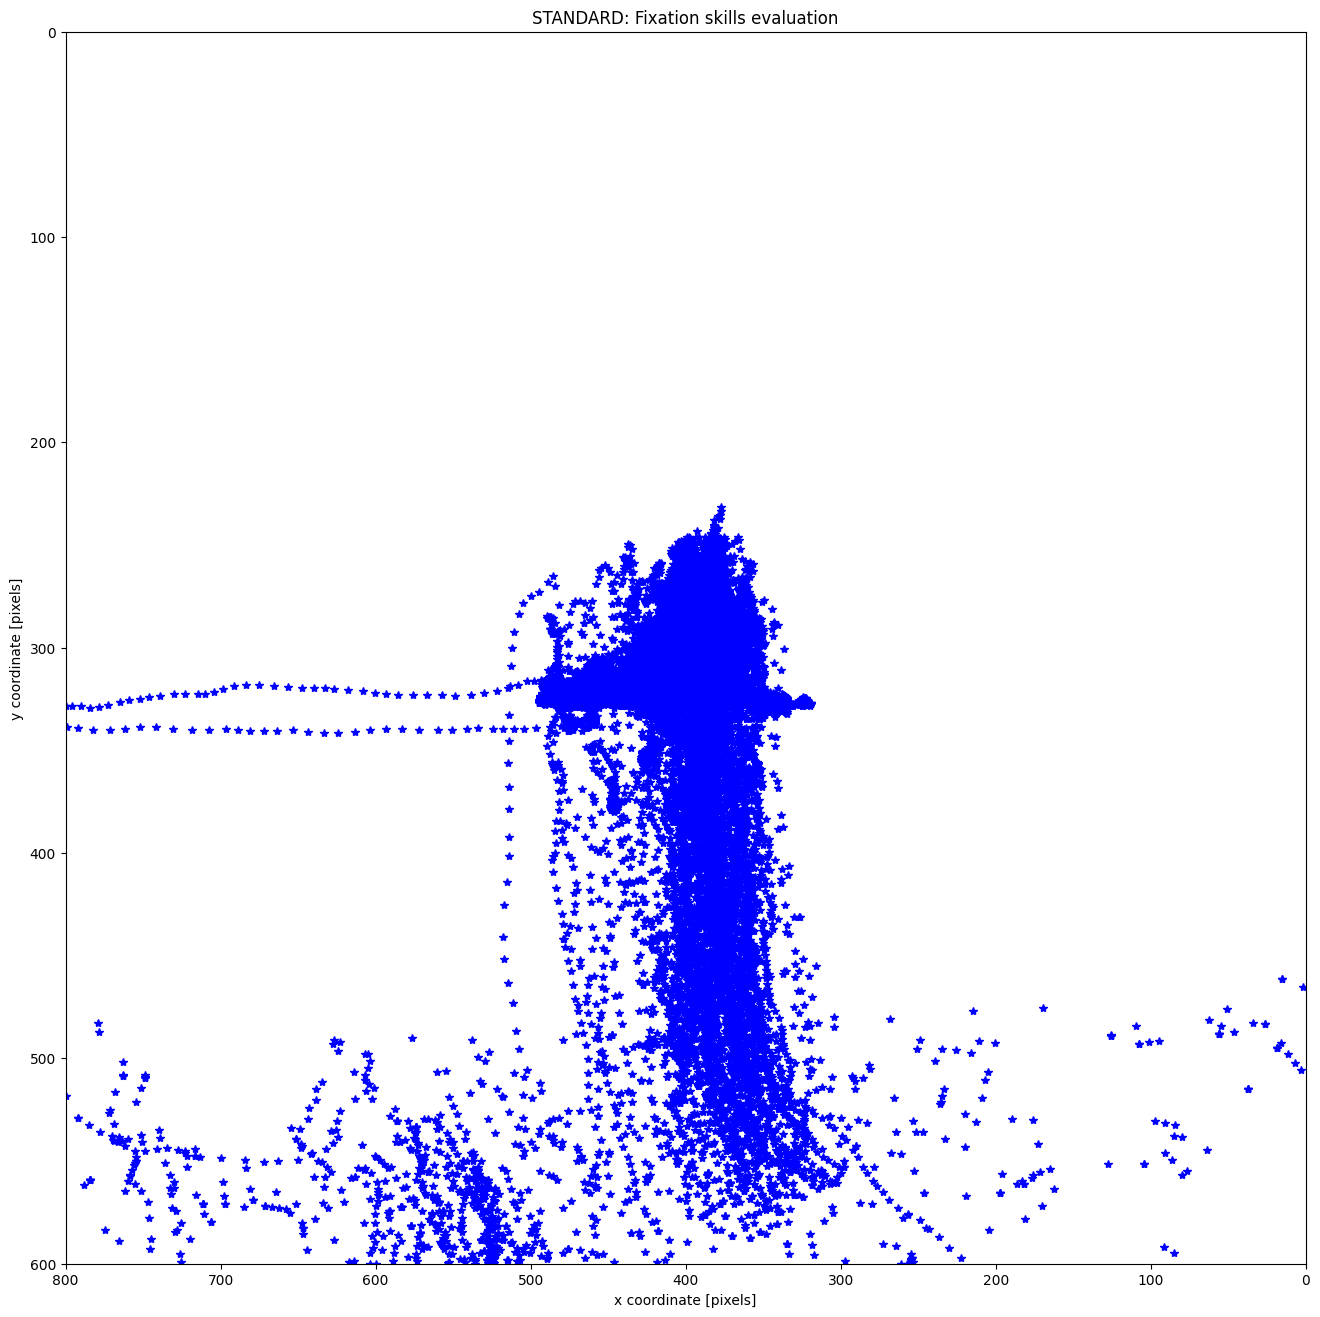

In [23]:
# Example data (replace with your actual data)
X_coord = coor_data_LIBRE_raw['x_coordinate']
Y_coord = coor_data_LIBRE_raw['y_coordinate']
fig, ax= plt.subplots(figsize=(16, 16))
# Plot the data, flipping X coordinates and using dots as markers
plt.plot(X_coord, Y_coord, '*', color='blue')
plt.xlim((0, 800))
plt.ylim((0, 600))
# Set plot title
plt.title('LIBRE: Fixation skills evaluation')
plt.xlabel('x coordinate [pixels]')
plt.ylabel('y coordinate [pixels]')
# Reverse the direction of the Y-axis
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

# ============================================================
# Example data (replace with your actual data)
X_coord = coor_data_LIBRE['x_coordinate']
Y_coord = coor_data_LIBRE['y_coordinate']
fig, ax= plt.subplots(figsize=(16, 16))
# Plot the data, flipping X coordinates and using dots as markers
plt.plot(X_coord, Y_coord, '*', color='blue')
plt.xlim((0, 800))
plt.ylim((0, 600))
# Set plot title
plt.title('LIBRE: Fixation skills evaluation')
plt.xlabel('x coordinate [pixels]')
plt.ylabel('y coordinate [pixels]')
# Reverse the direction of the Y-axis
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
# ============================================================
# Example data (replace with your actual data)
X_coord = coor_data_STANDARD['x_coordinate']
Y_coord = coor_data_STANDARD['y_coordinate']
fig, ax= plt.subplots(figsize=(16, 16))
# Plot the data, flipping X coordinates and using dots as markers
plt.plot(X_coord, Y_coord, '*', color='blue')
plt.xlim((0, 800))
plt.ylim((0, 600))
plt.xlabel('x coordinate [pixels]')
plt.ylabel('y coordinate [pixels]')
# Set plot title
plt.title('STANDARD: Fixation skills evaluation')
# Reverse the direction of the Y-axis
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()


By far, we initially cleaned data based on the inherent properties in the metadata from EyeLink. And we plotted the fixation evaluation,which show still distributed gazing dots instead of a clustered area. 

### Visual Angle

#### Method 1

In [159]:
def cal_disp(coor_data, stand_x=0.15, stand_y=0.15):
    Disp_dict = {}
    X_coord = coor_data["x_coordinate"].values
    Y_coord = coor_data["y_coordinate"].values
    print(f'X_coord {X_coord}')
    print(f'Y_coord {Y_coord}')
    print('After cleaning nan, eminating data affected by blinking,\
            and preserving the fixation ')
    print(f'The length of X coordinate data: {len(X_coord)}')
    print(f'The length of Y coordinate data: {len(Y_coord)}')

    # Distance head-coil projector 102 cm  - size of an emmetrope eye varies from 2.1 cm to 2.7 cm 
    # (eye with a perfect vision)
    # in mm - this is common to both horizontal and angular rotation. 24 is 2.4cm which is the size of eye
    Cat1 =  24 + 1020
    print('check here is the eye size is defined manually?  can we extract the info from metadata?')

    # Depends on projector resolution, where 176px corresponds to 81.3 mm; 
    # so the formula becomes (Recorded_traj_px - center in px)*81.3/176
    # computation measures in mm， convert from px to mm
    # Transfer from pixel domain to mm, and shift the displacement to the center of screen
    
    Cat2_hor = np.where(np.isnan(X_coord), np.nan, abs(X_coord - 400) * 81.3 / 176)
    Cat2_ver = np.where(np.isnan(Y_coord), np.nan, abs(Y_coord - 300) * 62 / 137)
    
    Hor_rot = np.where(np.isnan(Cat2_hor), np.nan, np.arctan(Cat2_hor / Cat1))
    Ver_rot = np.where(np.isnan(Cat2_ver), np.nan, np.arctan(Cat2_ver / Cat1))
#     print(Hor_rot)

    Disp_mm_eye_x =  np.tan(Hor_rot)*12 # 12: radius of the eye
    Disp_mm_eye_y =  np.tan(Ver_rot)*12
    print(f'Disp_mm_eye_x: {Disp_mm_eye_x}')
    
    Disp_dict['Disp_mm_eye'] = (Disp_mm_eye_x, Disp_mm_eye_y)

    med_x = np.nanmedian(Disp_mm_eye_x)
    print(f'med_x {med_x}')
    med_y = np.nanmedian(Disp_mm_eye_y)
    print(f'med_y {med_y}')
    Disp_dict['Disp_med'] = (med_x, med_y)
    # 0.5*std(Disp_mm_eye_y);

    # Subtract median
    Disp_mm_eye_x_minus_mx = Disp_mm_eye_x - med_x
    Disp_mm_eye_y_minus_my = Disp_mm_eye_y - med_y
    Disp_dict['Disp_mm_eye_minus_med'] = (Disp_mm_eye_x_minus_mx, Disp_mm_eye_y_minus_my)
    
    Ms_to_be_discarded_x_mask = (
            np.logical_or(
                Disp_mm_eye_x_minus_mx > stand_x,
                Disp_mm_eye_x_minus_mx < -stand_x
            ) | np.isnan(Disp_mm_eye_x_minus_mx)
        )
    Ms_to_be_discarded_y_mask = (
            np.logical_or(
                Disp_mm_eye_y_minus_my > stand_y,
                Disp_mm_eye_y_minus_my < -stand_y
            ) | np.isnan(Disp_mm_eye_y_minus_my)
        )
    Disp_dict['Ms_to_be_discarded_mask'] = (Ms_to_be_discarded_x_mask, Ms_to_be_discarded_y_mask)
    Disp_dict['stand_xy'] = (stand_x, stand_y)
    return Disp_dict


In [160]:
def plot_x_y_coord(Disp_dict, metadata, duration=None, start_sample=0, seq_name=None):
    from matplotlib.font_manager import FontProperties
    title_font = FontProperties(family='Times New Roman', size=24, weight='bold')
    
    Disp_mm_eye_x = Disp_dict['Disp_mm_eye'][0]
    Disp_mm_eye_y = Disp_dict['Disp_mm_eye'][1]
    Disp_mm_eye_x_minus_mx = Disp_dict['Disp_mm_eye_minus_med'][0]
    Disp_mm_eye_y_minus_my = Disp_dict['Disp_mm_eye_minus_med'][1]
    Ms_to_be_discarded_x_mask = Disp_dict['Ms_to_be_discarded_mask'][0]
    Ms_to_be_discarded_y_mask = Disp_dict['Ms_to_be_discarded_mask'][1]
    
    if duration == None:
        end_sample = len(Disp_mm_eye_x)
    else:    
        end_sample = duration*metadata["SamplingFrequency"]

    t_axis_xy = np.arange(start_sample, end_sample, 1)/metadata["SamplingFrequency"]

    # Horizontal direction!!!!!
    fig, ax= plt.subplots(figsize=(16, 8))
    
    ax.plot(
        t_axis_xy,
        Disp_mm_eye_x[start_sample:end_sample],
        marker='o', color='blue',
        label="Horizontal displacement in mm"
    )
    ax.plot(
        t_axis_xy,
        Disp_mm_eye_x_minus_mx[start_sample:end_sample],
        marker='*', color='green',
        label='Horizontal displacement in mm - med x'
    )

    if len(Ms_to_be_discarded_x_mask) != 0:
        ax.plot(
            t_axis_xy,
            Disp_mm_eye_x_minus_mx[start_sample:end_sample] * Ms_to_be_discarded_x_mask[start_sample:end_sample],
            marker='^', color='purple',
            label= 'MS to be discarded'
        )
    ax.axhline(y=Disp_dict['stand_xy'][0], color='r', linestyle='--', label='+std')
    ax.axhline(y=-Disp_dict['stand_xy'][0], color='r', linestyle='--', label='-std')
    ax.legend()
    ax.set_title(seq_name, fontproperties=title_font)
    plt.tight_layout()

    # Vertical direction!!!!!
    fig, ax= plt.subplots(figsize=(16, 8))
    ax.plot(
        t_axis_xy,
        Disp_mm_eye_y[start_sample:end_sample],
        marker='o', color='blue',
        label="Vertical displacement in mm"
    )
    ax.plot(
        t_axis_xy,
        Disp_mm_eye_y_minus_my[start_sample:end_sample],
        marker='*', color='green',
        label='Vertical displacement in mm - med x'
    )

    if len(Ms_to_be_discarded_y_mask) != 0:
        ax.plot(
            t_axis_xy,
            Disp_mm_eye_y_minus_my[start_sample:end_sample] * Ms_to_be_discarded_y_mask[start_sample:end_sample],
            marker='^', color='purple',
            label= 'MS to be discarded'
        )

    ax.axhline(y=Disp_dict['stand_xy'][1], color='r', linestyle='--', label='+std')
    ax.axhline(y=-Disp_dict['stand_xy'][1], color='r', linestyle='--', label='-std')
    ax.legend()
    ax.set_title(seq_name, fontproperties=title_font)
    plt.tight_layout()



In [161]:
from matplotlib.font_manager import FontProperties
title_font = FontProperties(family='Times New Roman', size=24, weight='bold')

def filter_XY_coord(coor_data, Disp_dict, seq_name=None):
    from matplotlib.font_manager import FontProperties
    title_font = FontProperties(family='Times New Roman', size=35, weight='bold')
    axis_font = FontProperties(family='Times New Roman', size=20)
#     x y coordinate accordingly
    X_coord = coor_data["x_coordinate"].values
    Y_coord = coor_data["y_coordinate"].values
    Ms_to_be_discarded_x_mask = Disp_dict['Ms_to_be_discarded_mask'][0]
    Ms_to_be_discarded_y_mask = Disp_dict['Ms_to_be_discarded_mask'][1]
    
    Combined_mask = ~(Ms_to_be_discarded_x_mask|Ms_to_be_discarded_y_mask)

    filtered_X_coord = X_coord * Combined_mask
    filtered_Y_coord = Y_coord * Combined_mask

    zero_mask = (filtered_X_coord == 0) & (filtered_Y_coord == 0)
    filtered_X_coord[zero_mask] = np.nan
    filtered_Y_coord[zero_mask] = np.nan

    # Example data (replace with your actual data)
    fig, ax= plt.subplots(figsize=(16, 16))
    # Plot the data, flipping X coordinates and using dots as markers
    plt.plot(filtered_X_coord, filtered_Y_coord, '.', color='#00468b',markersize=15)
    plt.xlim(0, 800)
    plt.ylim((0, 600))
    # Set plot title
    if seq_name is not None:
        plt.title(f'Fixation skills evaluation after screening: {seq_name}', fontproperties=title_font)
    else:     
        plt.title('Fixation skills evaluation after screening', fontproperties=title_font)

    # Reverse the direction of the Y-axis
    for label in plt.gca().get_xticklabels():
        label.set_fontproperties(axis_font)

    for label in plt.gca().get_yticklabels():
        label.set_fontproperties(axis_font)
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    
    coor_data["x_coordinate"] = filtered_X_coord
    coor_data["y_coordinate"] = filtered_Y_coord
    
    return coor_data, Combined_mask
    




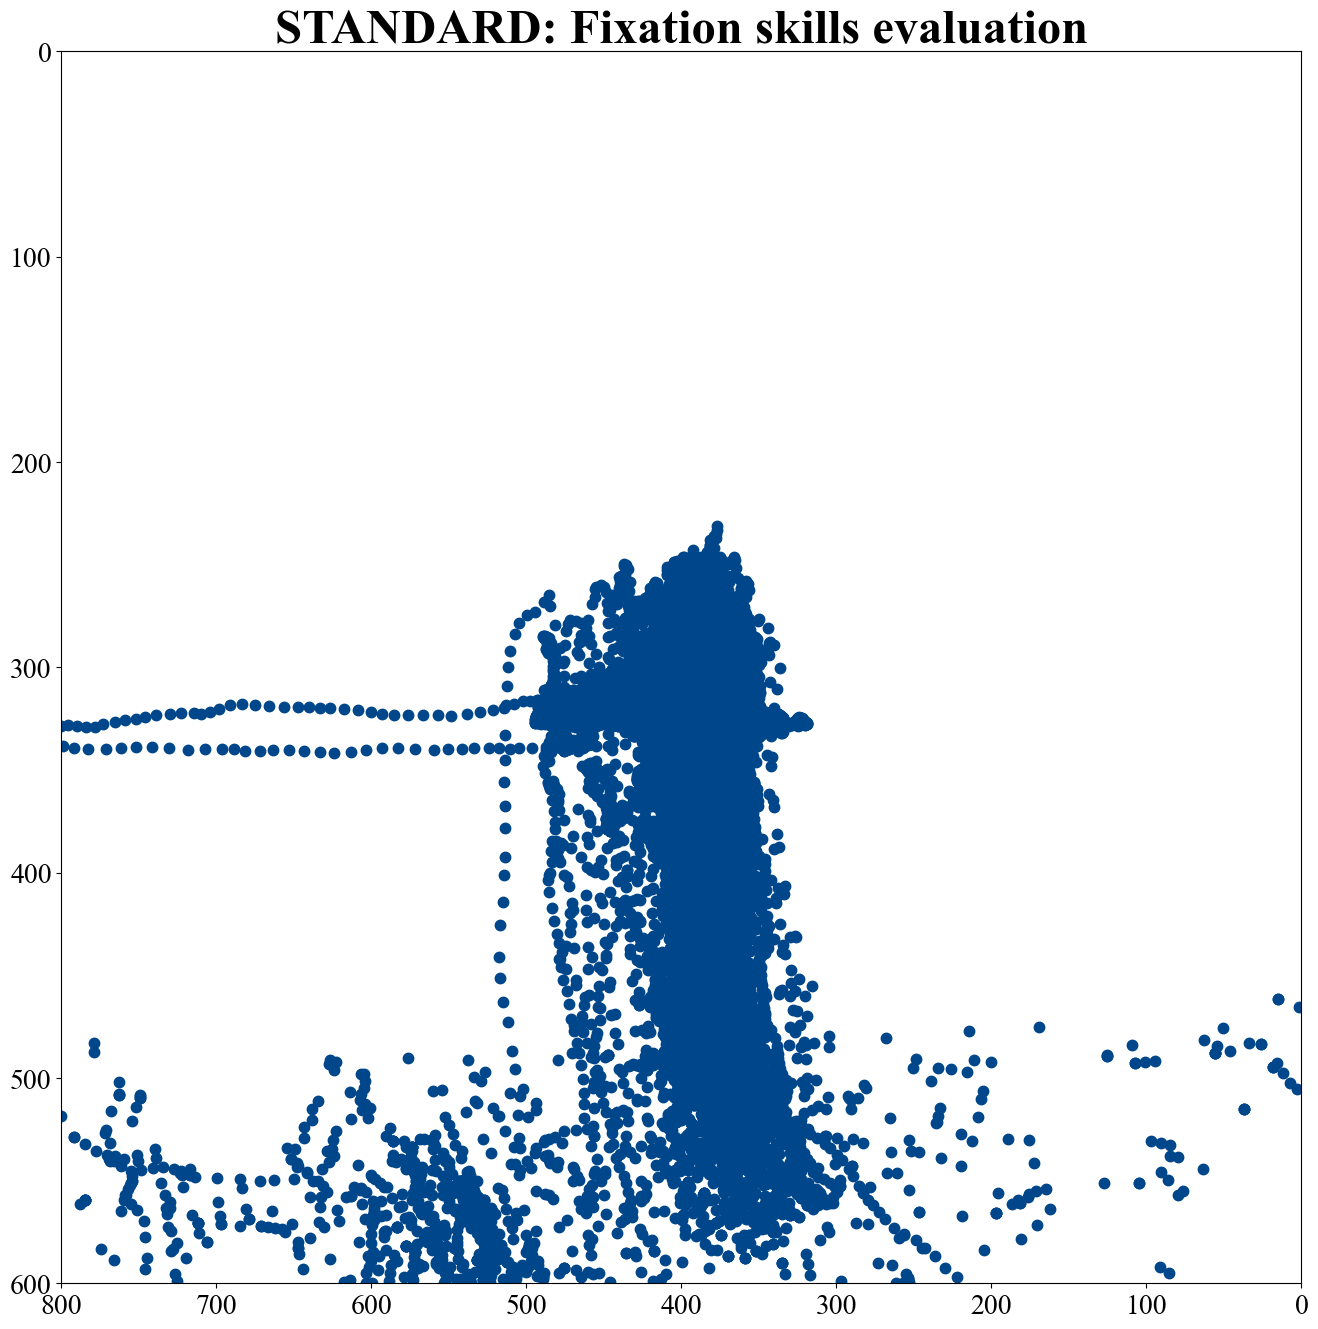

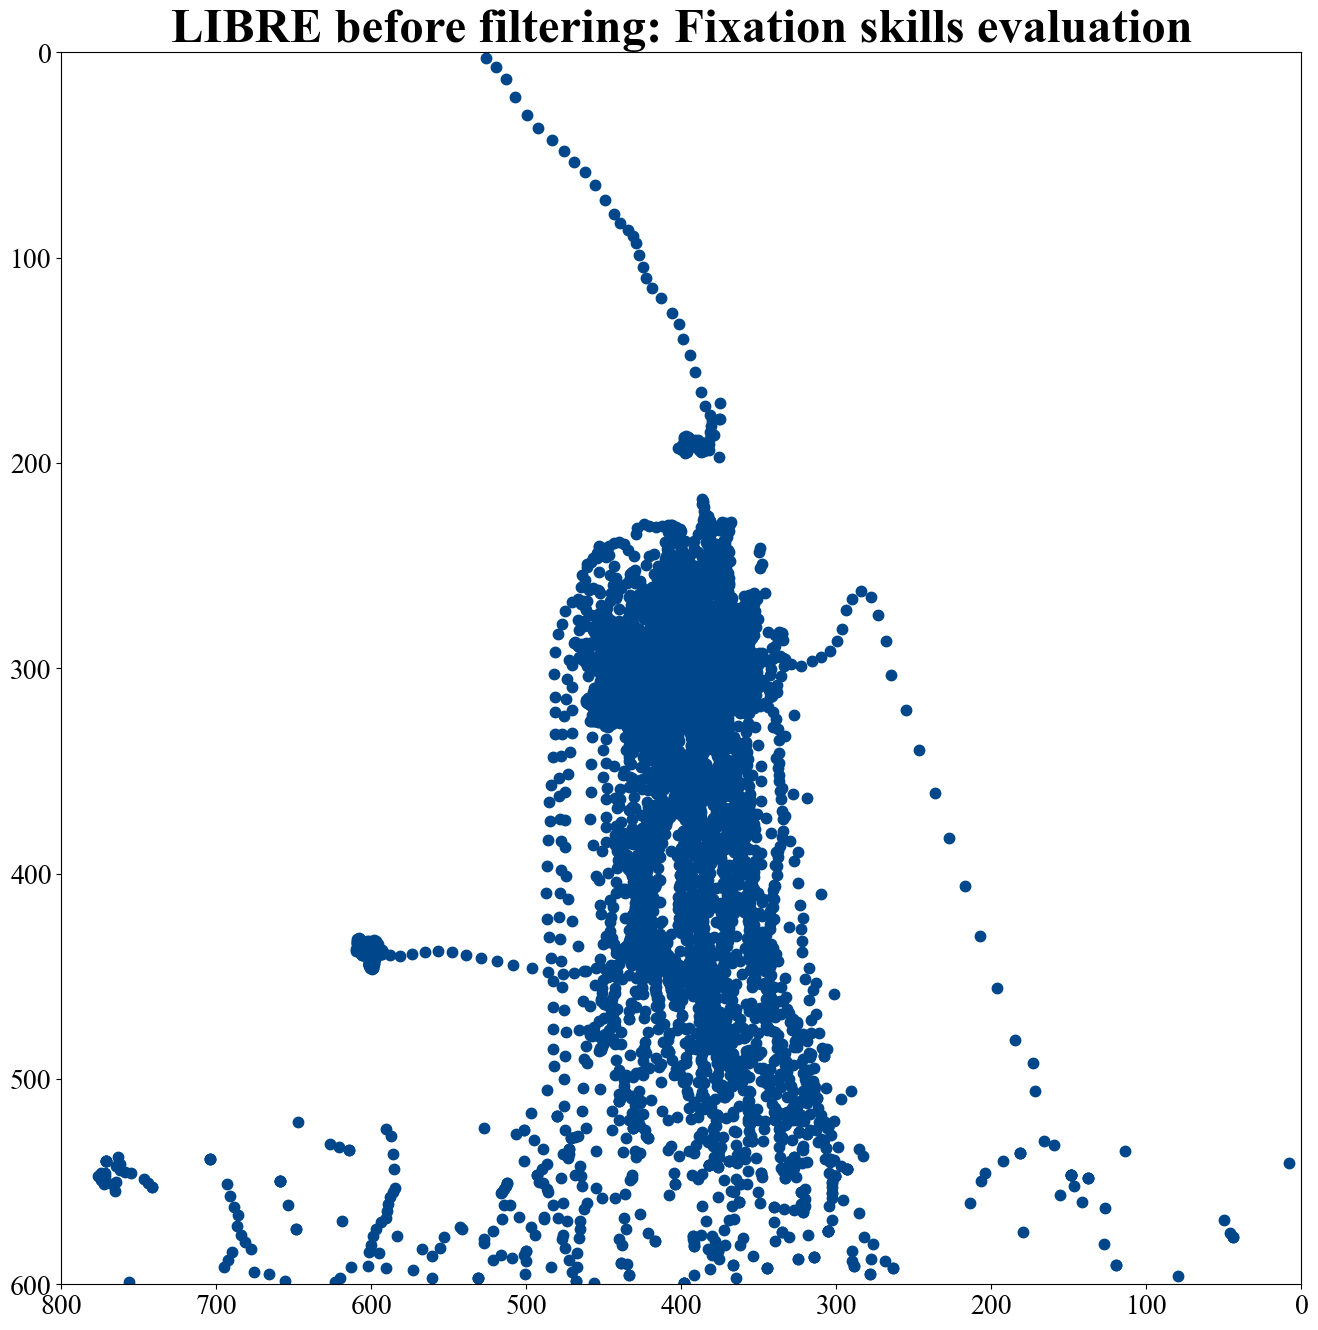

In [162]:
def plot_gaze_points(X_coord, Y_coord, fig_title):
    from matplotlib.font_manager import FontProperties
    title_font = FontProperties(family='Times New Roman', size=35, weight='bold')
    axis_font = FontProperties(family='Times New Roman', size=20)
    
    fig, ax= plt.subplots(figsize=(16, 16))
    # Plot the data, flipping X coordinates and using dots as markers
    plt.plot(X_coord, Y_coord, '.', color='#00468b', markersize=15)
    plt.tick_params(axis='x', labelsize=14)
    plt.tick_params(axis='y', labelsize=14)
    plt.xlim((0, 800))
    plt.ylim((0, 600))
    # Set plot title
    plt.title(fig_title, fontproperties=title_font)
    for label in plt.gca().get_xticklabels():
        label.set_fontproperties(axis_font)

    for label in plt.gca().get_yticklabels():
        label.set_fontproperties(axis_font)
    # Reverse the direction of the Y-axis
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    
#     ---------------------------------------------------------------------
X_coord = coor_data_STANDARD['x_coordinate']
Y_coord = coor_data_STANDARD['y_coordinate']
fig_title = 'STANDARD: Fixation skills evaluation'
plot_gaze_points(X_coord, Y_coord, fig_title)

coor_data_LIBRE_ = copy.deepcopy(coor_data_LIBRE_raw)
X_coord = coor_data_LIBRE_['x_coordinate']
Y_coord = coor_data_LIBRE_['y_coordinate']
fig_title = 'LIBRE before filtering: Fixation skills evaluation'
plot_gaze_points(X_coord, Y_coord, fig_title)

X_coord [        nan         nan         nan ... 398.8999939 398.5
 398.6000061]
Y_coord [         nan          nan          nan ... 302.1000061  301.79998779
 300.1000061 ]
After cleaning nan, eminating data affected by blinking,            and preserving the fixation 
The length of X coordinate data: 374558
The length of Y coordinate data: 374558
check here is the eye size is defined manually?  can we extract the info from metadata?
Disp_mm_eye_x: [       nan        nan        nan ... 0.00584055 0.00796434 0.00743335]
med_x 0.04990984220116117
med_y 0.03225109126906095


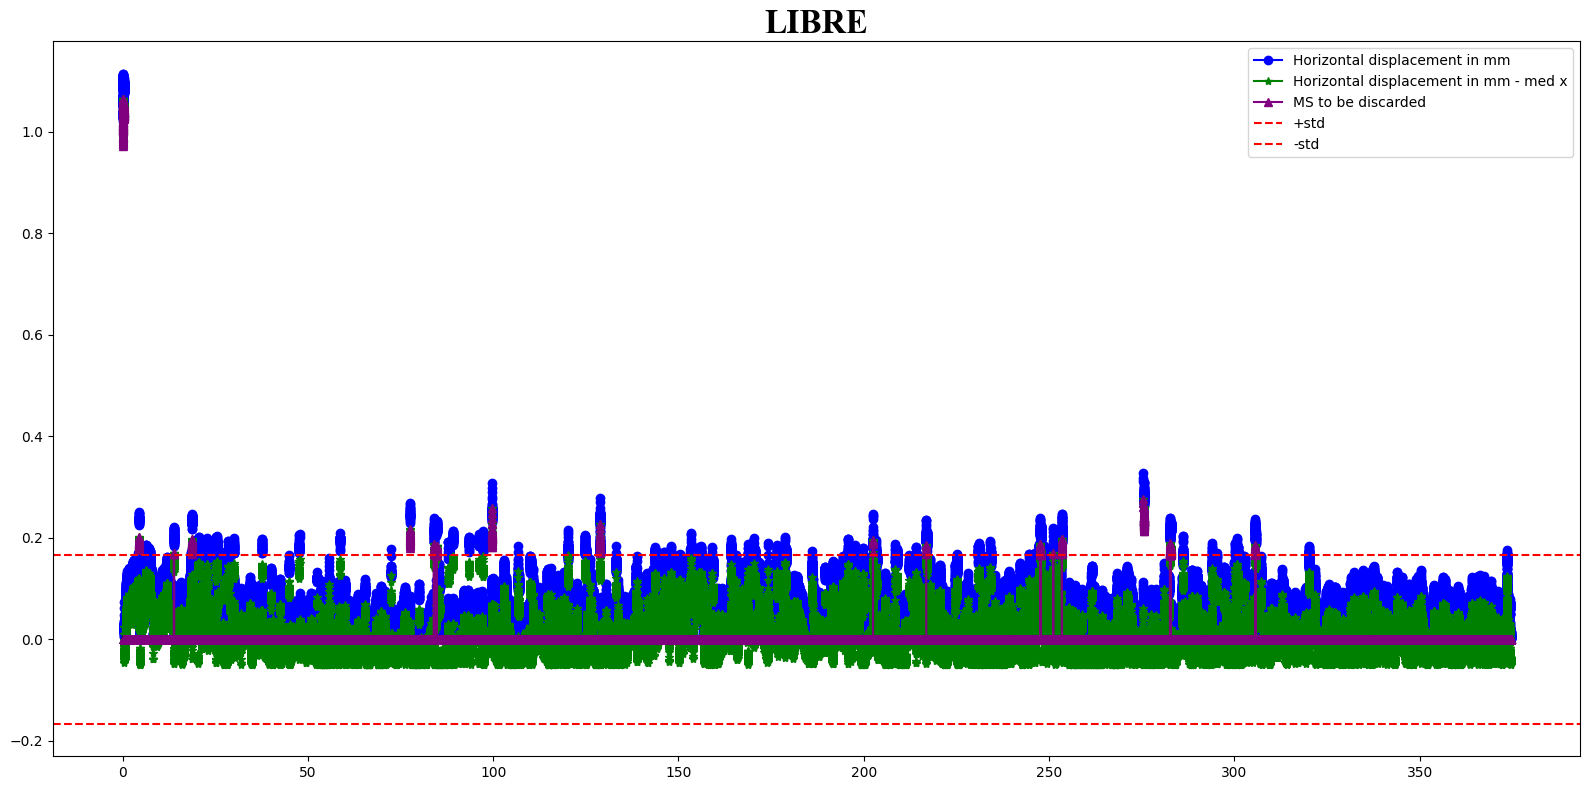

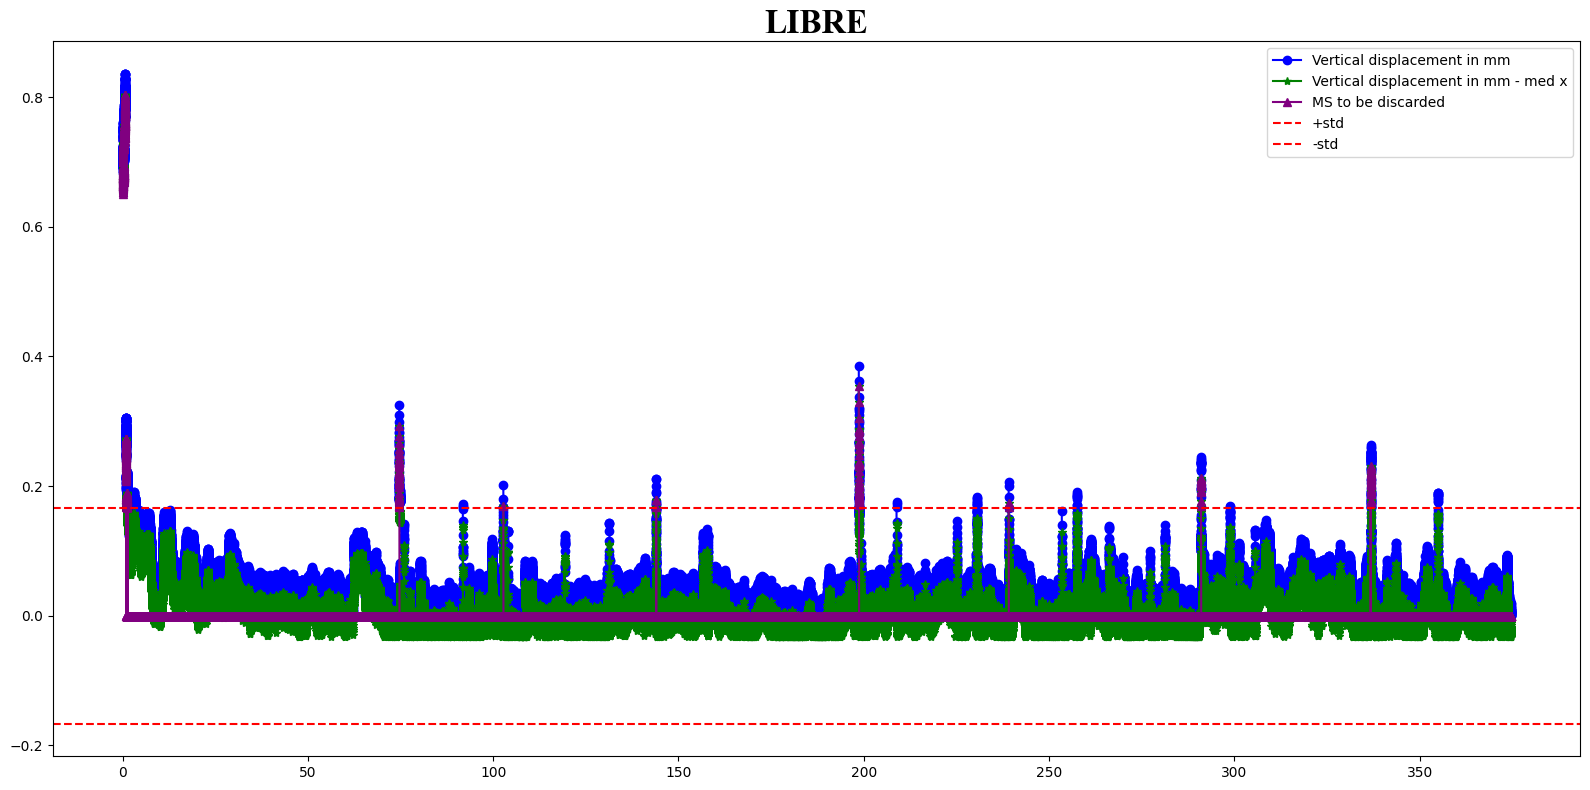

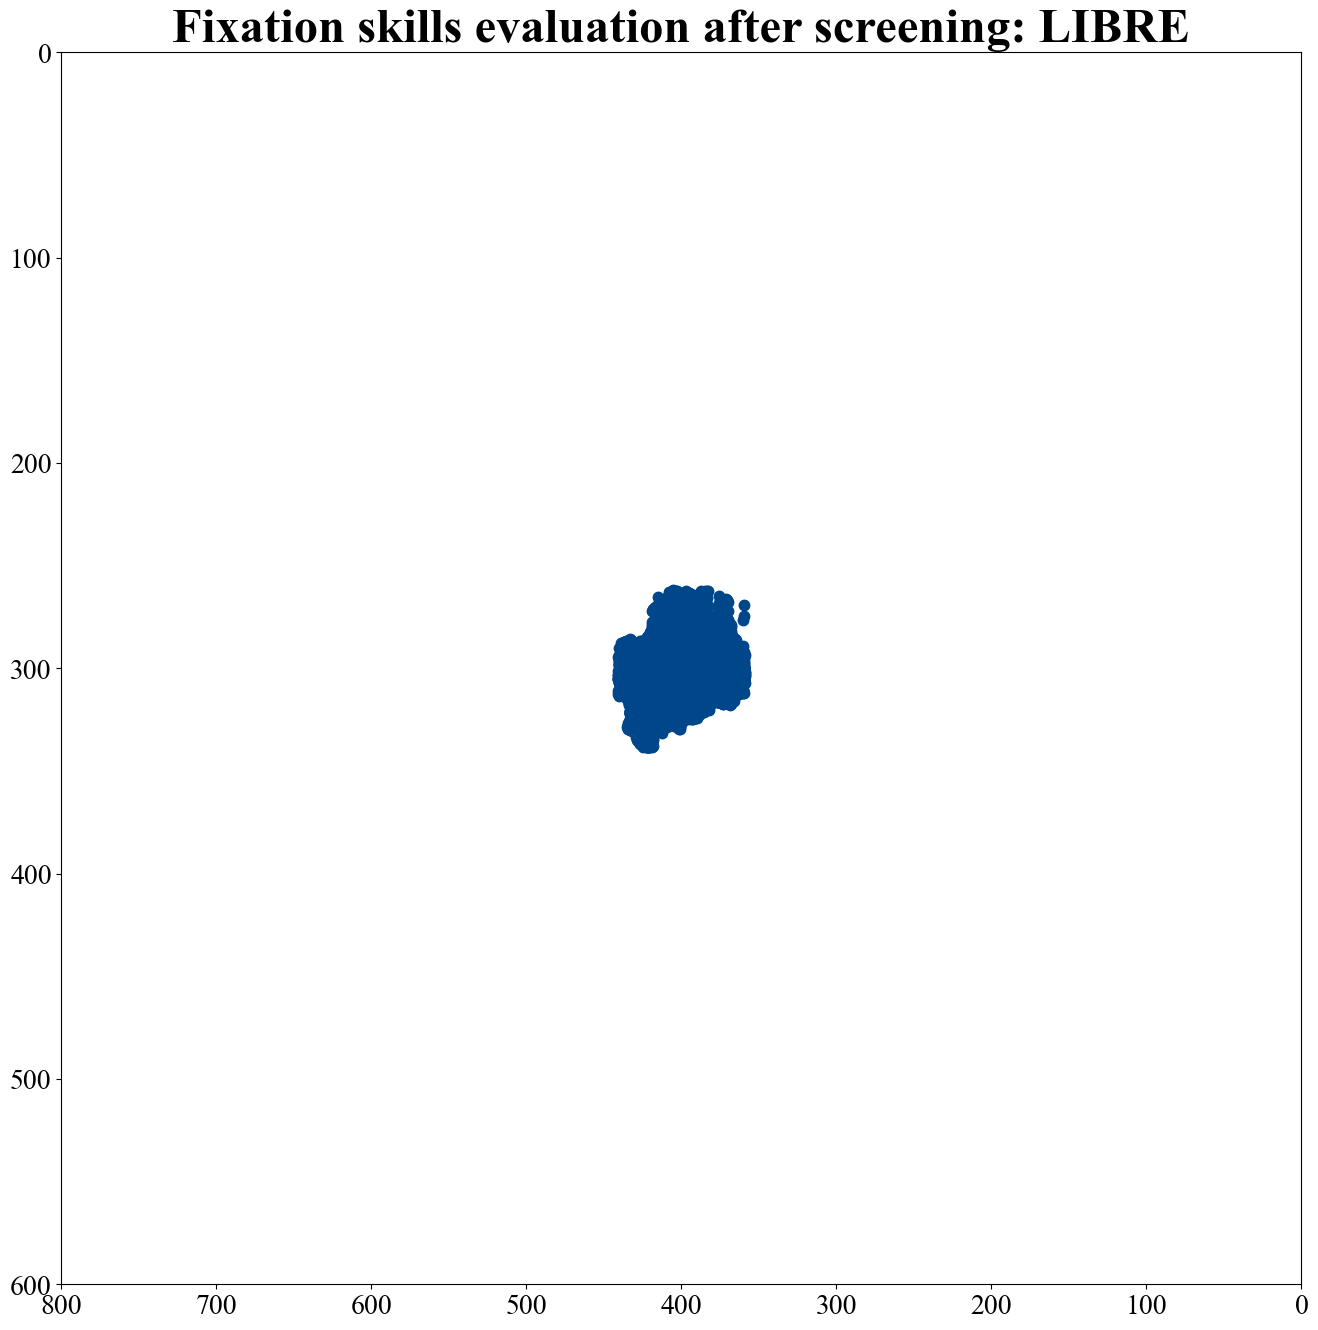

In [170]:
coor_data_LIBRE_1 = copy.deepcopy(coor_data_LIBRE)
Disp_dict_LIBRE = cal_disp(coor_data_LIBRE_1, stand_x=0.5*(1/3), stand_y=0.5*(1/3))
plot_x_y_coord(Disp_dict_LIBRE, metadata, duration=None, start_sample=0, seq_name='LIBRE')
filtered_coor_data_LIBRE, Preserve_mask = filter_XY_coord(coor_data_LIBRE_1, Disp_dict_LIBRE, 'LIBRE')


# coor_data_LIBRE_2 = copy.deepcopy(coor_data_LIBRE)
# Disp_dict_LIBRE = cal_disp(coor_data_LIBRE_2, stand_x=0.5*(1/3), stand_y=0.5*(1/3))
# plot_x_y_coord(Disp_dict_LIBRE, metadata, duration=None, start_sample=0, seq_name='LIBRE')
# filtered_coor_data_LIBRE = filter_XY_coord(coor_data_LIBRE_2, Disp_dict_LIBRE, 'LIBRE')

# coor_data_LIBRE_3 = copy.deepcopy(coor_data_LIBRE)
# Disp_dict_LIBRE = cal_disp(coor_data_LIBRE_3, stand_x=0.5*(1/4), stand_y=0.5*(1/4))
# plot_x_y_coord(Disp_dict_LIBRE, metadata, duration=None, start_sample=0, seq_name='LIBRE')
# filtered_coor_data_LIBRE = filter_XY_coord(coor_data_LIBRE_3, Disp_dict_LIBRE, 'LIBRE')

# plot_x_y_coord(Disp_dict_STANDARD, metadata, duration=None, start_sample=0, seq_name='STANDARD')

In [168]:
count_true = np.sum(Preserve_mask)
print(count_true)
# Save the Preserve_mask
import scipy.io as sio

mask_name = f'{FILE_NAME}_mask_meth1_0_33.mat'
if subject_idx == 1:
    SAVE_PATH = Path("C:\\yiwei\\240825_recon_for_poster\\Sub001\\T1_LIBRE_Binning\\BinningEYE_meas_MID00453_FID57919_BEAT_LIBREon_eye")
elif subject_idx == 2:
    SAVE_PATH = Path("C:\\yiwei\\240825_recon_for_poster\\Sub002\\T1_LIBRE_Binning\\BinningEYE_meas_MID00342_FID56821_BEAT_LIBREon_eye")

mask_file = SAVE_PATH / mask_name

# Save array to a .mat file
sio.savemat(mask_file, {'array': Preserve_mask})
print(f'The mask file has been saved here: {mask_file}')

347815
The mask file has been saved here: C:\yiwei\240825_recon_for_poster\Sub001\T1_LIBRE_Binning\BinningEYE_meas_MID00453_FID57919_BEAT_LIBREon_eye\JB1_mask_meth1_0_25.mat


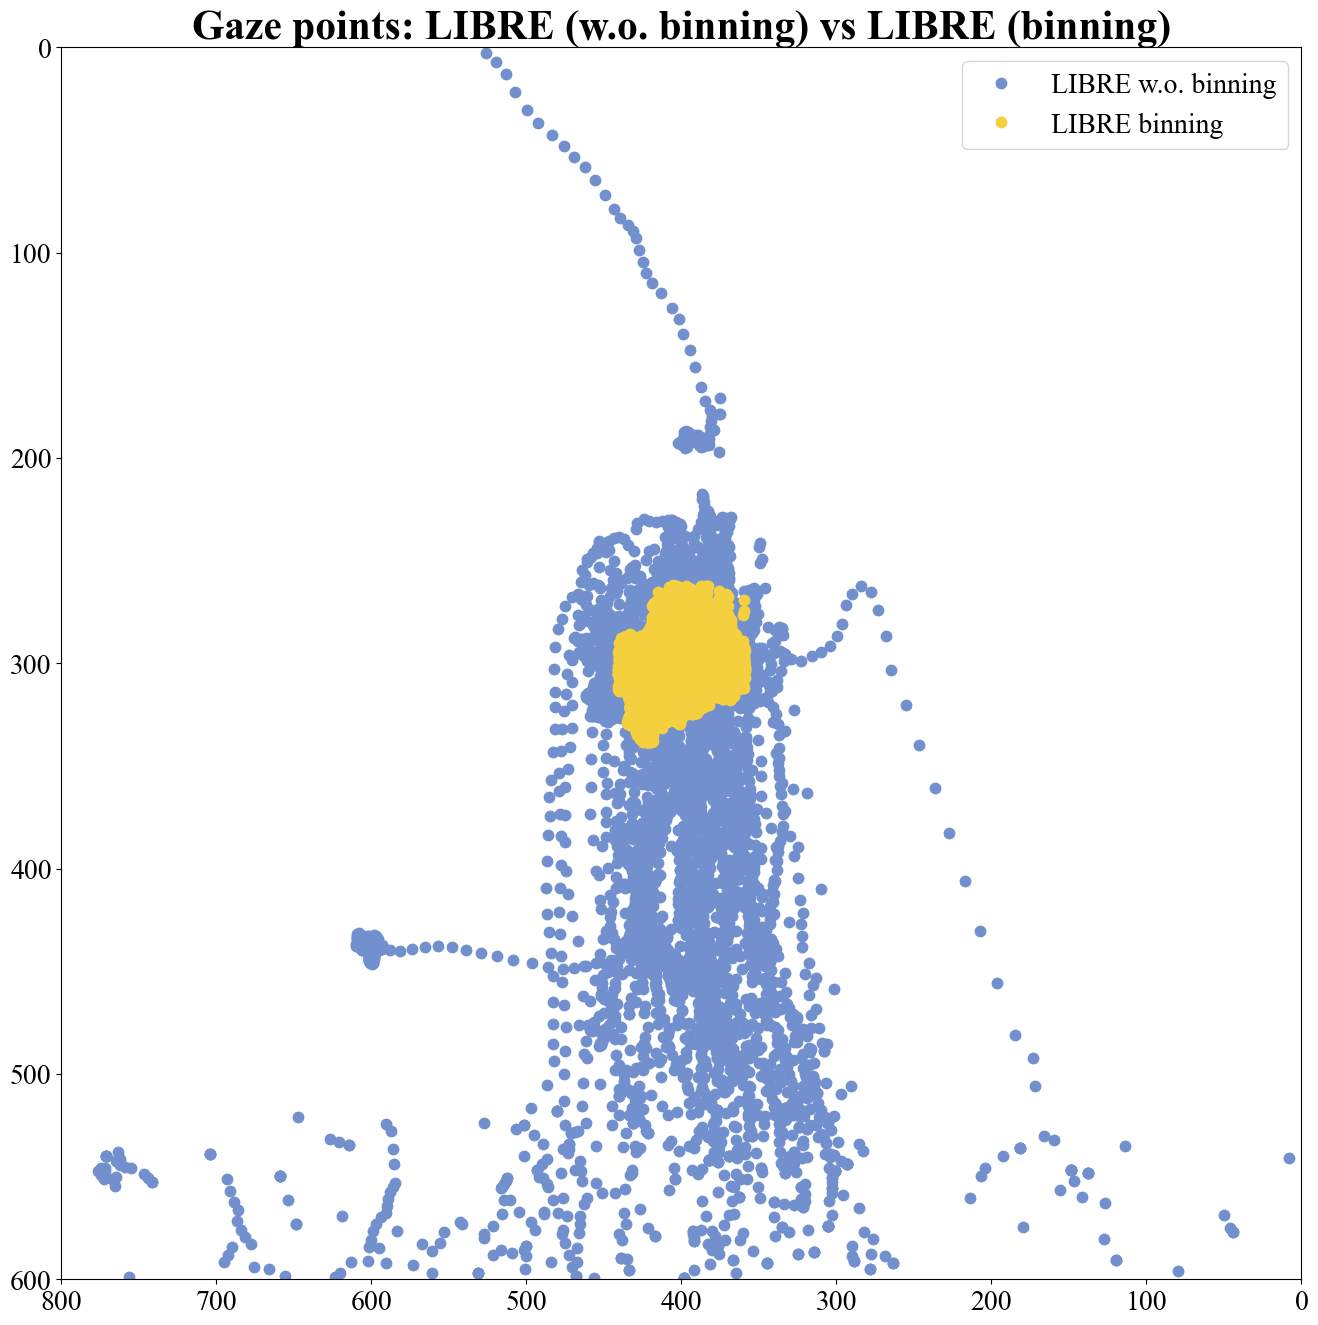

In [171]:
def visualization_func(fig_title):
    from matplotlib.font_manager import FontProperties
    title_font = FontProperties(family='Times New Roman', size=30, weight='bold')
    axis_font = FontProperties(family='Times New Roman', size=20)
    
    fig, ax= plt.subplots(figsize=(16, 16))
    plt.title(fig_title, fontproperties=title_font)
#     -----------------------------------------------------------------------
#     # Plot the data, flipping X coordinates and using dots as markers
#     X_coord = coor_data_STANDARD['x_coordinate']
#     Y_coord = coor_data_STANDARD['y_coordinate']
#     plt.plot(X_coord, Y_coord, '.', color='#ADD8E6', markersize=15, label='Standard')
#     -----------------------------------------------------------------------
    coor_data_LIBRE_vis = copy.deepcopy(coor_data_LIBRE)
    X_coord = coor_data_LIBRE_raw['x_coordinate']
    Y_coord = coor_data_LIBRE_raw['y_coordinate']

    plt.plot(X_coord, Y_coord, '.', color='#728FCE', markersize=15, label='LIBRE w.o. binning')
    
#     -----------------------------------------------------------------------
    X_coord = filtered_coor_data_LIBRE['x_coordinate']
    Y_coord = filtered_coor_data_LIBRE['y_coordinate']
    plt.plot(X_coord, Y_coord, '.', color='#f4d03f', markersize=15, label='LIBRE binning')
#     ----------------------------------------------------------------------------------------------
    plt.legend(prop={'family': 'Times New Roman', 'size': 20})
    
    plt.tick_params(axis='x', labelsize=14)
    plt.tick_params(axis='y', labelsize=14)
    plt.xlim((0, 800))
    plt.ylim((0, 600))
    # Set plot title
#     plt.title(fig_title, fontproperties=title_font)
    for label in plt.gca().get_xticklabels():
        label.set_fontproperties(axis_font)

    for label in plt.gca().get_yticklabels():
        label.set_fontproperties(axis_font)
    # Reverse the direction of the Y-axis
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()

visualization_func(fig_title='Gaze points: LIBRE (w.o. binning) vs LIBRE (binning)')

#### Method 2

In [184]:
def cal_radius(coor_data, stand_r=0.15):
    Disp_dict = {}
    X_coord = coor_data["x_coordinate"].values
    Y_coord = coor_data["y_coordinate"].values
    print(f'X_coord {X_coord}')
    print(f'Y_coord {Y_coord}')
    print('After cleaning nan, eminating data affected by blinking,\
            and preserving the fixation ')
    print(f'The length of X coordinate data: {len(X_coord)}')
    print(f'The length of Y coordinate data: {len(Y_coord)}')

    # Distance head-coil projector 102 cm  - size of an emmetrope eye varies from 2.1 cm to 2.7 cm 
    # (eye with a perfect vision)
    # in mm - this is common to both horizontal and angular rotation. 24 is 2.4cm which is the size of eye
    Cat1 =  24 + 1020
    print('check here is the eye size is defined manually?  can we extract the info from metadata?')

    # Depends on projector resolution, where 176px corresponds to 81.3 mm; 
    # so the formula becomes (Recorded_traj_px - center in px)*81.3/176
    # computation measures in mm， convert from px to mm
    # Transfer from pixel domain to mm, and shift the displacement to the center of screen
    Cat2_hor = np.where(np.isnan(X_coord), np.nan, abs(X_coord - 400) * 81.3 / 176)
    Cat2_ver = np.where(np.isnan(Y_coord), np.nan, abs(Y_coord - 300) * 62 / 137)
    
    Hor_rot = np.where(np.isnan(Cat2_hor), np.nan, np.arctan(Cat2_hor / Cat1))
    Ver_rot = np.where(np.isnan(Cat2_ver), np.nan, np.arctan(Cat2_ver / Cat1))

    Disp_mm_eye_x =  np.tan(Hor_rot)*12 # 12: radius of the eye
    Disp_mm_eye_y =  np.tan(Ver_rot)*12
    
    # Create a mask for np.nan values
    nan_mask = np.isnan(Disp_mm_eye_x) | np.isnan(Disp_mm_eye_y)

    # Calculate Disp_radius while handling np.nan
    Disp_radius = np.where(
        nan_mask,
        np.nan,  # If either Disp_mm_eye_x or Disp_mm_eye_y is nan, set Disp_radius to nan
        np.sqrt(Disp_mm_eye_x ** 2 + Disp_mm_eye_y ** 2)  # Otherwise, compute the radius
    )
    
    Disp_dict['Disp_mm_eye'] = (Disp_mm_eye_x, Disp_mm_eye_y)
    Disp_dict['Disp_radius'] = Disp_radius

    med_x = np.nanmedian(Disp_radius)
    print(f'med_x {med_x}')
    med_y = np.nanmedian(Disp_mm_eye_y)
    print(f'med_y {med_y}')
    Disp_dict['Disp_med'] = (med_x, med_y)
    
    med_r = np.nanmedian(Disp_radius)
    Disp_dict['Disp_med_r'] = med_r
  
    # 0.5*std(Disp_mm_eye_y);

    # Subtract median
    Disp_mm_eye_x_minus_mx = Disp_mm_eye_x - med_x
    Disp_mm_eye_y_minus_my = Disp_mm_eye_y - med_y
    Disp_mm_eye_r_minus_mr = Disp_radius - med_r
    
    Disp_dict['Disp_mm_eye_minus_med'] = (Disp_mm_eye_x_minus_mx, Disp_mm_eye_y_minus_my)
    Disp_dict['Disp_mm_eye_r_minus_mr'] = Disp_mm_eye_r_minus_mr
    print(f'Disp_mm_eye_r_minus_mr {Disp_mm_eye_r_minus_mr}')
    Ms_to_be_discarded_r_mask = (Disp_mm_eye_r_minus_mr > stand_r)|np.isnan(Disp_mm_eye_r_minus_mr)

    Disp_dict['Ms_to_be_discarded_mask'] = Ms_to_be_discarded_r_mask
    Disp_dict['stand_r'] = stand_r
    
    return Disp_dict


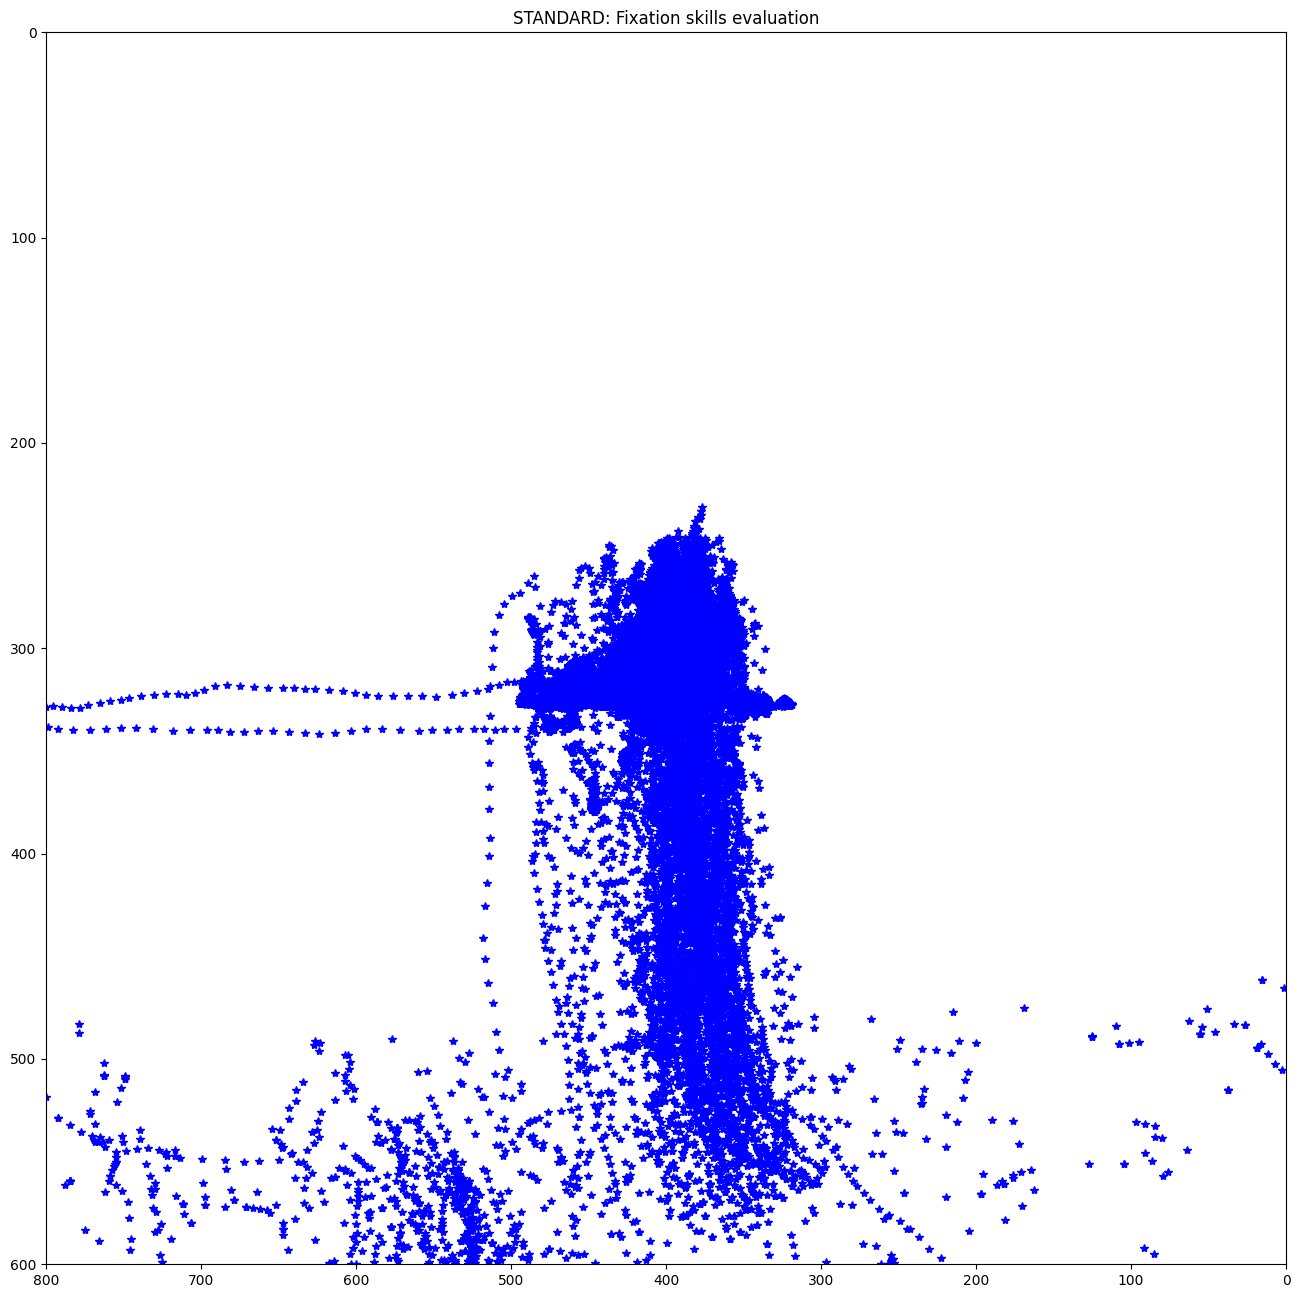

In [185]:
def filter_r_coord(coor_data, Disp_dict, seq_name=None):
#     x y coordinate accordingly
    X_coord = coor_data["x_coordinate"].values
    Y_coord = coor_data["y_coordinate"].values
    Ms_to_be_discarded_r_mask = Disp_dict['Ms_to_be_discarded_mask']
    
    Preserve_mask = ~(Ms_to_be_discarded_r_mask)

    filtered_X_coord = X_coord * Preserve_mask
    filtered_Y_coord = Y_coord * Preserve_mask

    zero_mask = (filtered_X_coord == 0) & (filtered_Y_coord == 0)
    filtered_X_coord[zero_mask] = np.nan
    filtered_Y_coord[zero_mask] = np.nan

    # Example data (replace with your actual data)
    fig, ax= plt.subplots(figsize=(16, 16))
    # Plot the data, flipping X coordinates and using dots as markers
    plt.plot(filtered_X_coord, filtered_Y_coord, '*', color='blue')
    plt.xlim(0, 800)
    plt.ylim((0, 600))
    # Set plot title
    if seq_name is not None:
        plt.title(f'Fixation skills evaluation after screening: {seq_name}')
    else:     
        plt.title('Fixation skills evaluation after screening')

    # Reverse the direction of the Y-axis
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    
    coor_data["x_coordinate"] = filtered_X_coord
    coor_data["y_coordinate"] = filtered_Y_coord
    
    return coor_data, Preserve_mask
    

# Example data (replace with your actual data)
X_coord = coor_data_STANDARD['x_coordinate']
Y_coord = coor_data_STANDARD['y_coordinate']
fig, ax= plt.subplots(figsize=(16, 16))
# Plot the data, flipping X coordinates and using dots as markers
plt.plot(X_coord, Y_coord, '*', color='blue')
plt.xlim((0, 800))
plt.ylim((0, 600))
# Set plot title
plt.title('STANDARD: Fixation skills evaluation')
# Reverse the direction of the Y-axis
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

In [186]:
def plot_r_coord(Disp_dict, metadata, duration=None, start_sample=0, seq_name=None):
    Disp_mm_eye_x = Disp_dict['Disp_mm_eye'][0]
    Disp_mm_eye_y = Disp_dict['Disp_mm_eye'][1]
    Disp_radius = Disp_dict['Disp_radius']
    
    Disp_mm_eye_x_minus_mx = Disp_dict['Disp_mm_eye_minus_med'][0]
    Disp_mm_eye_y_minus_my = Disp_dict['Disp_mm_eye_minus_med'][1]
    Disp_mm_eye_r_minus_mr = Disp_dict['Disp_mm_eye_r_minus_mr']
    
    
    Ms_to_be_discarded_r_mask = Disp_dict['Ms_to_be_discarded_mask']
    stand_r = Disp_dict['stand_r']
    
    if duration == None:
        end_sample = len(Disp_mm_eye_x)
    else:    
        end_sample = duration*metadata["SamplingFrequency"]

    t_axis_xy = np.arange(start_sample, end_sample, 1)/metadata["SamplingFrequency"]

    # radius direction!!!!!
    fig, ax= plt.subplots(figsize=(16, 8))
    
    ax.plot(
        t_axis_xy,
        Disp_radius[start_sample:end_sample],
        marker='o', color='blue',
        label="Radial displacement in mm"
    )
    ax.plot(
        t_axis_xy,
        Disp_mm_eye_r_minus_mr[start_sample:end_sample],
        marker='*', color='green',
        label='Radial displacement in mm - med r'
    )

    if len(Ms_to_be_discarded_r_mask) != 0:
        ax.plot(
            t_axis_xy,
            Disp_mm_eye_r_minus_mr[start_sample:end_sample] * Ms_to_be_discarded_r_mask[start_sample:end_sample],
            marker='^', color='purple',
            label= 'MS to be discarded'
        )
    ax.axhline(y=Disp_dict['stand_r'], color='r', linestyle='--', label='+std')
    ax.axhline(y=-Disp_dict['stand_r'], color='r', linestyle='--', label='-std')
    ax.legend()
    ax.set_title(seq_name)
    plt.tight_layout()



X_coord [         nan          nan          nan ... 398.29998779 398.1000061
 398.1000061 ]
Y_coord [         nan          nan          nan ... 305.20001221 303.1000061
 300.8999939 ]
After cleaning nan, eminating data affected by blinking,            and preserving the fixation 
The length of X coordinate data: 362000
The length of Y coordinate data: 362000
check here is the eye size is defined manually?  can we extract the info from metadata?
med_x 0.06692429486183482
med_y 0.03277114213978207
Disp_mm_eye_r_minus_mr [        nan         nan         nan ... -0.03840869 -0.04790316
 -0.05580281]


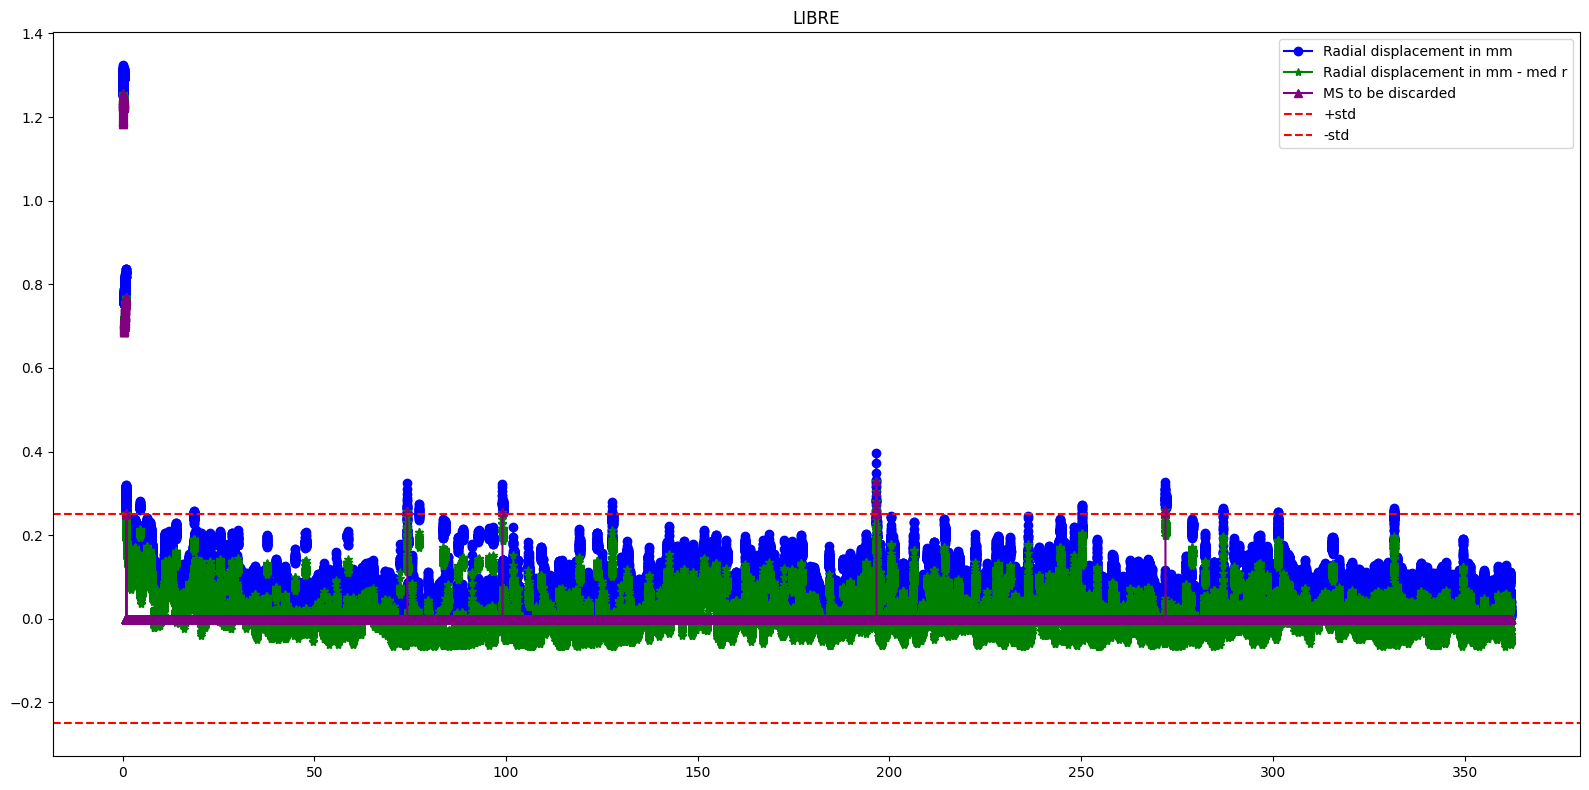

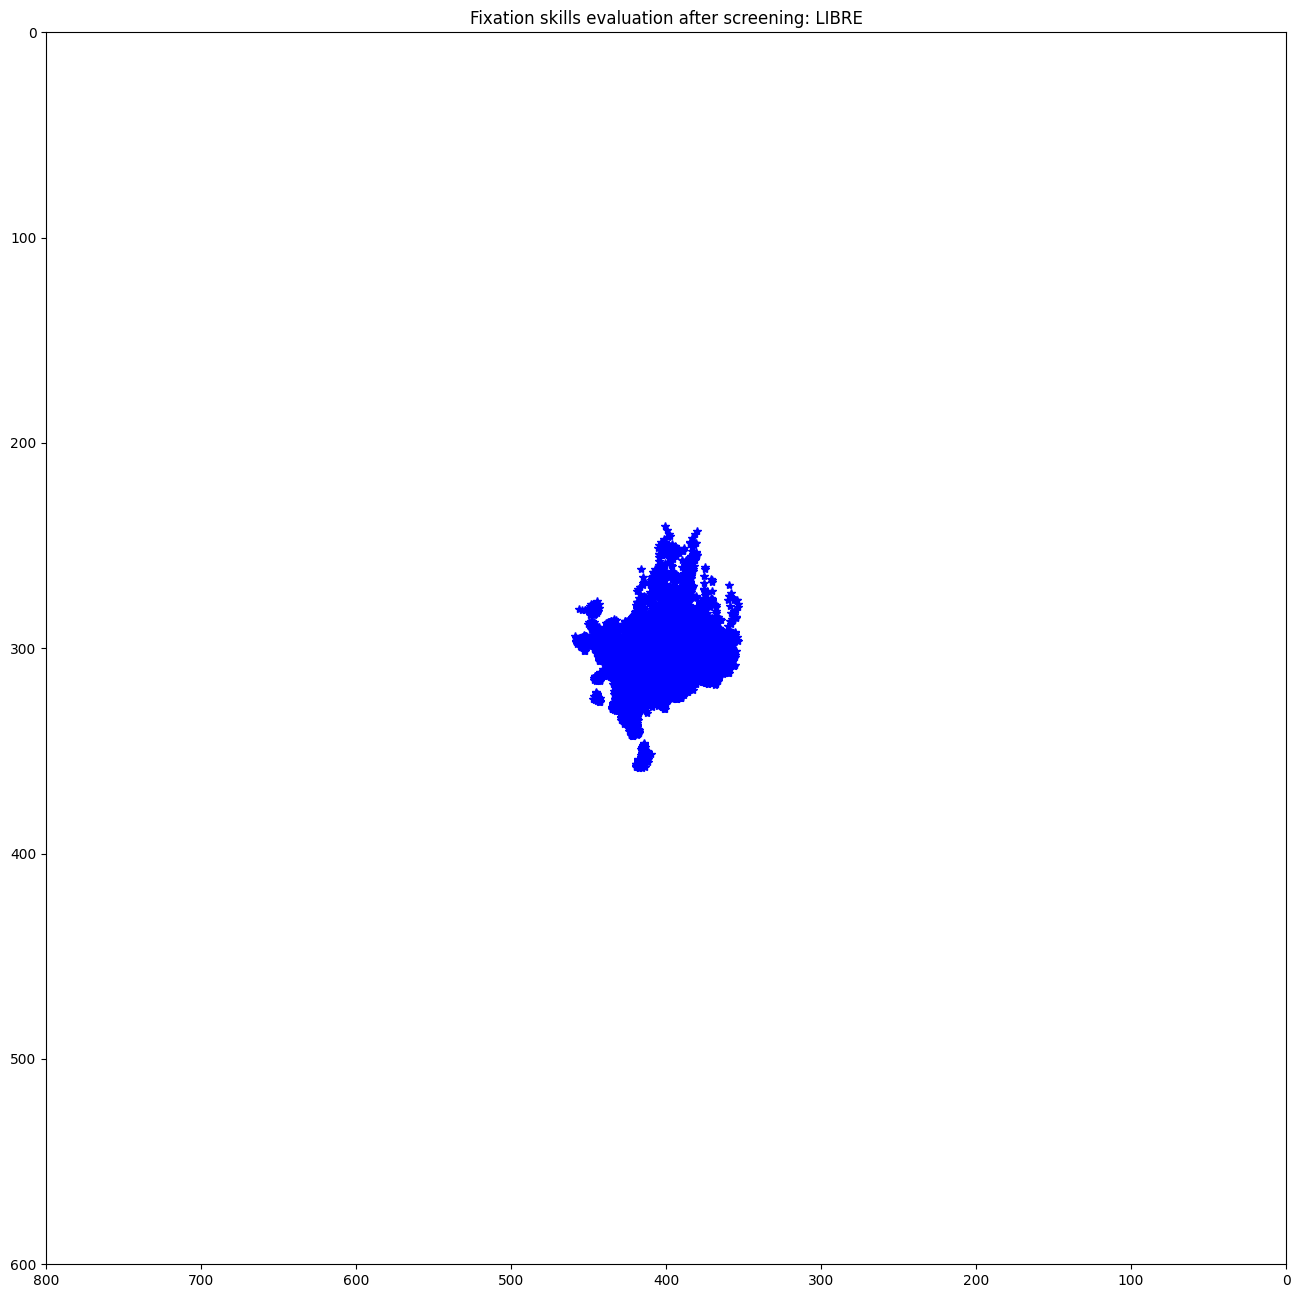

In [187]:
coor_data_LIBRE_4 = copy.deepcopy(coor_data_LIBRE)
Disp_dict_LIBRE = cal_radius(coor_data_LIBRE_4, stand_r=0.5*(1/2))
plot_r_coord(Disp_dict_LIBRE, metadata, duration=None, start_sample=0, seq_name='LIBRE')
filtered_coor_data_LIBRE, Preserve_mask = filter_r_coord(coor_data_LIBRE_4, Disp_dict_LIBRE, 'LIBRE')

# coor_data_LIBRE_5 = copy.deepcopy(coor_data_LIBRE)
# Disp_dict_LIBRE = cal_radius(coor_data_LIBRE_5, stand_r=0.5*(1/3))
# plot_r_coord(Disp_dict_LIBRE, metadata, duration=None, start_sample=0, seq_name='LIBRE')
# filtered_coor_data_LIBRE = filter_r_coord(coor_data_LIBRE_5, Disp_dict_LIBRE, 'LIBRE')

# coor_data_LIBRE_6 = copy.deepcopy(coor_data_LIBRE)
# Disp_dict_LIBRE = cal_radius(coor_data_LIBRE_6, stand_r=0.5*(1/4))
# plot_r_coord(Disp_dict_LIBRE, metadata, duration=None, start_sample=0, seq_name='LIBRE')
# filtered_coor_data_LIBRE = filter_r_coord(coor_data_LIBRE_6, Disp_dict_LIBRE, 'LIBRE')

# plot_x_y_coord(Disp_dict_STANDARD, metadata, duration=None, start_sample=0, seq_name='STANDARD')

In [190]:
count_discard = np.sum(Disp_dict_LIBRE['Ms_to_be_discarded_mask'])
count_discard

16728